In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pandapower as pp
from pandapower.networks import case14, case_ieee30, case118, case300, case4gs
from gekko import GEKKO
from pandapower.plotting.plotly import pf_res_plotly
import pandapower.plotting as pplot
from msc_rafael_pavan import otimizacao_pso_discreto_sengi
from msc_rafael_pavan import inicializa_sep
from msc_rafael_pavan import matriz_condutancia
from msc_rafael_pavan import coleta_dados_vbus
from msc_rafael_pavan import coleta_dados_gen
from msc_rafael_pavan import func_objetivo
from msc_rafael_pavan import pen_tensao
from msc_rafael_pavan import pen_ger_reativo
from msc_rafael_pavan import coleta_dados_trafo
from msc_rafael_pavan import pen_trafo
from msc_rafael_pavan import coleta_dados_bshunt
from msc_rafael_pavan import converte_trafo
from msc_rafael_pavan import cria_alcateia
from msc_rafael_pavan import cria_enxame
from msc_rafael_pavan import pen_bshunt
from msc_rafael_pavan import fluxo_de_pot
from msc_rafael_pavan import fitness
from msc_rafael_pavan import validacao
from msc_rafael_pavan import validacao_q
from msc_rafael_pavan import fluxo_de_pot_q

from msc_rafael_pavan import otimizacao_gwo_continuo
from msc_rafael_pavan import otimizacao_pso_continuo
from msc_rafael_pavan import discreto_bshunt
from msc_rafael_pavan import discreto_tap
from msc_rafael_pavan import otimizacao_gwo_discreto
from msc_rafael_pavan import otimizacao_pso_discreto
from msc_rafael_pavan import otimizacao_clpso_discreto
from msc_rafael_pavan import ipm_ieee30
from msc_rafael_pavan import ipm_ieee14
from msc_rafael_pavan import cria_enxame_v
import copy

from numba import jit
import time

sep_14 = case14()
sep_118 = case118()
sep_300 = case300()
sep_30 = case_ieee30()

v_init30 = inicializa_sep(sep_30,algorithm='fdbx', relatorio=False)

sep_14 = case14()
v_init14 = inicializa_sep(sep_14,algorithm='fdbx', relatorio=False)
sep_118 = case118()
v_init118 = inicializa_sep(sep_118,algorithm='fdbx', relatorio=False)

v_init300 = inicializa_sep(sep_300,algorithm='fdbx', relatorio=False)


In [2]:
a = sep_14.trafo['tap_pos'].values

In [3]:
def otimizacao_clpso_discreto_fpo(sep, refresh_gap, p1_,p2_,zeta, psi, sigma, omega, neta,max_iter, n_particles,c1,c2,v_amp,valor_inicial,step, wmax,wmin,relatorio=True,inicial=True):
        
    enxame_fit = cria_enxame_fpo(sep,n_particles)
    
    
    

        
    if len(sep.bus) == 14:
        
        n_vgen = 4+1
        n_tap = 3
        n_gens = 4
        n_bshunt = 1
    
    if len(sep.bus) == 30:
        
        n_vgen = 5+1
        n_tap = 4
        n_bshunt = 2
        n_gens = 5
        
    
    if len(sep.bus) == 118:
        
        n_vgen = 53+1
        n_tap = 9
        n_bshunt = 14
        n_gens=53
        
        
    if len(sep.bus) == 300:
        
        n_vgen = 68+1
        n_tap = 62
        n_bshunt = 29
        n_gens=68
    
  
        
    
    w_max=wmax
    w_min=wmin
    
    
    
    j = []
    
    
    tempo = []
        
    obj = []
    
    pen_v = []
    
    pen_gq = []
    
    pen_tap = []
    
    pen_bsh = []
    
    pen_slack = []

    
    v_lim_superior = np.repeat(sep.bus['max_vm_pu'][0], n_vgen)
    
    v_lim_inferior = np.repeat(sep.bus['min_vm_pu'][0], n_vgen)
    
    tap_pos, tap_neutral, tap_step_percent,valores_taps = coleta_dados_trafo(sep,relatorio=False)
    
    tap_max = np.repeat(valores_taps[-1], len(tap_pos)) 
    
    tap_min = np.repeat(valores_taps[0], len(tap_pos)) 
    
    max_pot = sep.gen['max_p_mw'].values/100    
    min_pot = sep.gen['min_p_mw'].values/100
    
    bsh,b=coleta_dados_bshunt(sep)

    bsh_max=[]
    
    bsh_min=[]
    
    l_v =[]
    l_q=[]
    l_p=[]
    l_o =[]
    
    refresh_rate = np.zeros((n_particles))
    

    for bs in bsh:
        bsh_max.append([np.max(bs) - 1e-4])
        bsh_min.append([np.min(bs) + 1e-4])


    maximo = np.expand_dims(np.concatenate((v_lim_superior, tap_max, bsh_max, max_pot), axis = None), 0)
    minimo = np.expand_dims(np.concatenate((v_lim_inferior, tap_min, bsh_min, min_pot), axis = None), 0)
     
    
    lim_sup = np.tile(maximo, (n_particles,1))
    lim_inf = np.tile(minimo, (n_particles,1))
    
    v_anterior = v_amp*cria_enxame_fpo(sep,n_particles)
    
    delta= np.abs(lim_sup-lim_inf)[0,:]
    xk = []

    if inicial == True:
        
        for i in range(int(n_particles/2)):
            
            enxame_fit[i,:]=valor_inicial + np.concatenate((delta,np.array([0,0,0,0,0,0,0])))*np.random.randn(1, enxame_fit.shape[1])*0.01
            
            
    for i in range(0,max_iter):
        

            
        start = time.time()
        
        
        r1 = np.random.random_sample(size = (n_particles,enxame_fit.shape[1]))
        
        r2 = np.random.random_sample(size = (n_particles,enxame_fit.shape[1]))

        enxame_fit_d = np.copy(enxame_fit)
    
        for linha in range(n_particles):
          
            enxame_fit_d[linha][n_vgen:n_vgen+n_tap] = discreto_tap(enxame_fit[linha].copy(),n_tap,n_vgen,n_bshunt,sep)
            enxame_fit_d[linha][n_vgen+n_tap:n_vgen+n_tap+n_bshunt] = discreto_bshunt(enxame_fit[linha].copy(),n_tap,n_vgen,n_bshunt,sep)
            enxame_fit_d[linha][n_vgen+n_tap+n_bshunt:n_vgen+n_tap+n_bshunt+n_gens] = poz(n_vgen, n_tap, n_bshunt, n_gens, enxame_fit[linha].copy(), sep)[n_vgen+n_tap+n_bshunt:n_vgen+n_tap+n_bshunt+n_gens] 
            
        if i>=50:
            
            print('AC')
            enxame_fit[:,-7:] = (fluxo_de_pot_fpo(enxame_fit_d,sep))[:,-7:]
            
            if zz==1:
            
                best_particles[:,-7:] = (fluxo_de_pot_fpo(best_particles,sep))[:,-7:]
                best_particles[:,-7:] = (fitness_fpo(best_particles,zeta,psi,sigma,omega,neta))[:,-7:]
                zz=0
        else:
            
            print('DC')
            enxame_fit[:,-7:] = (fluxo_de_pot_fpo_dc(enxame_fit_d,sep))[:,-7:]
            zz=1
             
            
        enxame_fit[:,-7:] = (fitness_fpo(enxame_fit,zeta,psi,sigma,omega,neta))[:,-7:]
       
        xk.append(enxame_fit.copy())
       
        
        if i==0:
            
            best_particles = enxame_fit.copy()
            
            global_best = best_particles[np.argsort(best_particles[:, -1])][0,:].copy()
            
            global_matriz = np.tile(global_best, (n_particles,1))
            
            
            pbestfi = np.copy(best_particles)
        
        
        
        
        for t in range(0,n_particles):
                
            if (enxame_fit[t,-1] < best_particles[t,-1]):
        
                best_particles[t,:] = enxame_fit[t,:].copy()
            
                refresh_rate[t] = 0
            
            else: refresh_rate[t] = refresh_rate[t] + 1
        
        ps = np.arange(start=1,stop=n_particles+1,step=1)
                
        prob = p1_ + p2_*(np.exp((10*(ps-1)/(n_particles-1)))-1)/(np.exp(10)-1)
                                                
        global_best = best_particles[np.copy(np.argsort(best_particles[:, -1]))][0,:]
        
        
        for li in range(n_particles):
            
            if refresh_rate[li] >= refresh_gap:
                
                pbestfi[li,:]=best_particles[li,:]
                
                refresh_rate[li] = 0

                for co in range(len(global_best)-7):
                                           
                    
                    if np.random.rand()<= prob[li]:

                        p1 = int(np.floor(n_particles*np.random.rand()))

                        p2 = int(np.floor(n_particles*np.random.rand()))

                        while(p1==p2):


                            p1 = int(np.floor(n_particles*np.random.rand()))

                            p2 = int(np.floor(n_particles*np.random.rand()))


                        part1 = best_particles[p1,:]

                        part2 = best_particles[p2,:]

                        if part1[-1] <= part2[-1]:

                            pbestfi[li,co] = part1[co]

                        else:
                            pbestfi[li,co] = part2[co]


        
        global_matriz = np.tile(global_best, (n_particles,1))   
            
        enxame_fit_anterior = enxame_fit.copy()
            
    
        w_novo = w_max-(w_max-w_min)*(i+1)/max_iter 
            
                        
        v_novo = np.multiply(w_novo,v_anterior.copy()) + c1*np.multiply(r1,(pbestfi.copy()-enxame_fit.copy())) + c2*np.multiply(r2,(global_matriz.copy()-enxame_fit.copy()))
        
        
        for l in range(v_novo.shape[0]):
        
            for c in range(len(delta)):
                
                if v_novo[l,c] > delta[c]*step:
                    
                    v_novo[l,c] = delta[c]*step
                    
                    
                if v_novo[l,c] < -delta[c]*step:
                    
                    v_novo[l,c] = -delta[c]*step
                    
        
#         if i<1:
#             enxame_fit_novo = enxame_fit_anterior  + v_novo
        
#         if i>=1:


#             for p in range(0,n_particles): 

                
                
#                 for coluna in range(len(global_best)):
                        
#                     if xk[i][p,-1] > xk[i-1][p,-1]:
                            
#                         enxame_fit_novo[p,coluna] = xk[i][p,coluna].copy()  + v_novo[p,coluna]
                        
#                     if xk[i][p,-1] < xk[i-1][p,-1]:

#                         if xk[i][p,coluna] > xk[i-1][p,coluna]:

#                             enxame_fit_novo[p,coluna] = xk[i][p,coluna].copy()  + 1*np.abs(v_novo[p,coluna])

#                         if xk[i][p,coluna] == xk[i-1][p,coluna]:

#                             enxame_fit_novo[p,coluna] = xk[i][p,coluna].copy()  + 0*v_novo[p,coluna]

#                         if xk[i][p,coluna] < xk[i-1][p,coluna]:

#                             enxame_fit_novo[p,coluna] = xk[i][p,coluna].copy() + -1*np.abs(v_novo[p,coluna])
                            
        enxame_fit_novo = enxame_fit_anterior  + v_novo
        
    
        v_anterior = v_novo.copy()
        
#         delta = lim_sup[0,:]-lim_inf[0,:]
        
#         step = 0.25
        
#         for k in range(int(n_particles/10)):
            
#             mutacao=(np.random.randn(len(global_best[:-6])))*step*delta
            
#             posi = np.random.randint(0,n_particles)
            
#             enxame_fit_novo[posi,:-6] = enxame_fit_novo[posi,:-6] + mutacao
            
        
        
#         for linha in range(n_particles):
          
#             enxame_fit_novo[linha][n_vgen:n_vgen+n_tap] = discreto_tap(enxame_fit_novo[linha],n_tap,n_vgen,n_bshunt,sep)
#             enxame_fit_novo[linha][n_vgen+n_tap:n_vgen+n_tap+n_bshunt] = discreto_bshunt(enxame_fit_novo[linha],n_tap,n_vgen,n_bshunt,sep)
            
        
        
        enxame_estat = enxame_fit_novo[:,-7:]

        enxame_fit = np.concatenate(( np.clip(enxame_fit_novo[:,0:-7], a_min = lim_inf, a_max = lim_sup, out = enxame_fit_novo[:,0:-7]),enxame_estat),axis=1)   

        end = time.time()

        elapsed = end - start

        j.append(global_best[-1])

        obj.append(global_best[-7])

        pen_v.append(global_best[-6])

        pen_gq.append(global_best[-5])

        pen_tap.append(global_best[-4])

        pen_bsh.append(global_best[-3])
        
        pen_slack.append(global_best[-2])
        
        tempo.append(elapsed)
      

        if relatorio == True:
            
            print(' ')

            print('Melhor Global da Iteração:',i)

            print('Objetivo:', global_best[-7])

            print('Penalização de Tensão:', global_best[-6])

            print('Penalização de Geração de Reativo:', global_best[-5])
            
            print('Penalização do Gerador Slack (P):', global_best[-2])

            print('Fitness:', global_best[-1])

            
            print('Tempo: ', elapsed)

            print(' ')

            print('_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ ')
            
            
    
    if relatorio == True:
        
            plt.figure(figsize=(18,10))
            plt.plot(obj)
            
            plt.title('Otimização Por Enxame de Partículas')
            plt.ylabel('Objetivo')
            plt.xlabel('Número da Iteração')
            
            plt.figure(figsize=(18,10))
            plt.plot(j)
            
            plt.title('Otimização Por Enxame de Partículas')
            plt.ylabel('Fitness (J)')
            plt.xlabel('Número da Iteração')
            
            plt.figure(figsize=(18,10))
            plt.plot(pen_v)
            plt.title('Otimização Por Enxame de Partículas')
            plt.ylabel('Penalização de Tensão')
            plt.xlabel('Número da Iteração')
            
            plt.figure(figsize=(18,10))
            plt.plot(pen_gq)
            plt.title('Otimização Por Enxame de Partículas')
            plt.ylabel('Penalização de Geração de Reativo')
            plt.xlabel('Número da Iteração')
            
            plt.figure(figsize=(18,10))
            plt.plot(pen_tap)
            plt.title('Otimização Por Enxame de Partículas')
            plt.ylabel('Penalização do TAP')
            plt.xlabel('Número da Iteração')
            
            plt.figure(figsize=(18,10))
            plt.plot(pen_bsh)
            plt.title('Otimização Por Enxame de Partículas')
            plt.ylabel('Penalização do BShunt')
            plt.xlabel('Número da Iteração')
                       
            
    return j,obj,pen_v,pen_gq,pen_tap,pen_bsh, pen_slack, global_best, tempo, delta


In [4]:
def otimizacao_pso_discreto_fpo(sep, refresh_gap, p1_,p2_,zeta, psi, sigma, omega, neta,max_iter, n_particles,c1,c2,v_amp,valor_inicial,step, wmax,wmin,relatorio=True,inicial=True):
        
    enxame_fit = cria_enxame_fpo(sep,n_particles)
    
    
    

        
    if len(sep.bus) == 14:
        
        n_vgen = 4+1
        n_tap = 3
        n_gens = 4
        n_bshunt = 1
    
    if len(sep.bus) == 30:
        
        n_vgen = 5+1
        n_tap = 4
        n_bshunt = 2
        n_gens = 5
        
    
    if len(sep.bus) == 118:
        
        n_vgen = 53+1
        n_tap = 9
        n_bshunt = 14
        n_gens=53
        
        
    if len(sep.bus) == 300:
        
        n_vgen = 68+1
        n_tap = 62
        n_bshunt = 29
        n_gens=68
    
  
        
    
    w_max=wmax
    w_min=wmin
    
    
    
    j = []
    
    
    tempo = []
        
    obj = []
    
    pen_v = []
    
    pen_gq = []
    
    pen_tap = []
    
    pen_bsh = []
    
    pen_slack = []

    
    v_lim_superior = np.repeat(sep.bus['max_vm_pu'][0], n_vgen)
    
    v_lim_inferior = np.repeat(sep.bus['min_vm_pu'][0], n_vgen)
    
    tap_pos, tap_neutral, tap_step_percent,valores_taps = coleta_dados_trafo(sep,relatorio=False)
    
    tap_max = np.repeat(valores_taps[-1], len(tap_pos))
    
    tap_min = np.repeat(valores_taps[0], len(tap_pos))
    
    max_pot = sep.gen['max_p_mw'].values/100
    
    min_pot = sep.gen['min_p_mw'].values/100
    
    bsh,b=coleta_dados_bshunt(sep)

    bsh_max=[]
    
    bsh_min=[]
    
    l_v =[]
    l_q=[]
    l_p=[]
    l_o =[]
    
    refresh_rate = np.zeros((n_particles))
    

    for bs in bsh:
        bsh_max.append([np.max(bs)])
        bsh_min.append([np.min(bs)])


    maximo = np.expand_dims(np.concatenate((v_lim_superior, tap_max, bsh_max, max_pot), axis = None), 0)
    minimo = np.expand_dims(np.concatenate((v_lim_inferior, tap_min, bsh_min, min_pot), axis = None), 0)
     
    
    lim_sup = np.tile(maximo, (n_particles,1))
    lim_inf = np.tile(minimo, (n_particles,1))
    
    v_anterior = v_amp*cria_enxame_fpo(sep,n_particles)
    
    delta= np.abs(lim_sup-lim_inf)[0,:]
    xk = []

    if inicial == True:
        
        for i in range(int(n_particles/2)):
            
            enxame_fit[i,:]=valor_inicial + np.concatenate((delta,np.array([0,0,0,0,0,0,0])))*np.random.randn(1, enxame_fit.shape[1])*0.01
            
            
    for i in range(0,max_iter):
        

            
        start = time.time()
        
        r1 = np.random.random_sample(size = (n_particles,enxame_fit.shape[1]))
        
        r2 = np.random.random_sample(size = (n_particles,enxame_fit.shape[1]))

        enxame_fit_d = np.copy(enxame_fit)
    
        for linha in range(n_particles):
          
            enxame_fit_d[linha][n_vgen:n_vgen+n_tap] = discreto_tap(enxame_fit[linha].copy(),n_tap,n_vgen,n_bshunt,sep)
            enxame_fit_d[linha][n_vgen+n_tap:n_vgen+n_tap+n_bshunt] = discreto_bshunt(enxame_fit[linha].copy(),n_tap,n_vgen,n_bshunt,sep)
            enxame_fit_d[linha][n_vgen+n_tap+n_bshunt:n_vgen+n_tap+n_bshunt+n_gens] = poz(n_vgen, n_tap, n_bshunt, n_gens, enxame_fit[linha].copy(), sep)[n_vgen+n_tap+n_bshunt:n_vgen+n_tap+n_bshunt+n_gens] 
            
        enxame_fit[:,-7:] = (fluxo_de_pot_fpo(enxame_fit_d,sep))[:,-7:]
     
        enxame_fit[:,-7:] = (fitness_fpo(enxame_fit,zeta,psi,sigma,omega,neta))[:,-7:]
       
        xk.append(enxame_fit.copy())
       
        
        if i==0:
            
            best_particles = enxame_fit.copy()

            l_q.append(enxame_fit[:,-5])

            l_o.append(enxame_fit[:,-7])
            l_p.append(enxame_fit[:,-2])
            l_v.append(enxame_fit[:,-6])

            max_v = np.max(l_v) 

            min_v = np.min(l_v)

            max_o = np.max(l_o)

            min_o = np.min(l_o)

            max_q = np.max(l_q)

            min_q = np.min(l_q)


            max_p = np.max(l_p)
            min_p = np.min(l_p)

            bpq = (best_particles[:,-5]-min_q)/(max_q-min_q+1e-15)

            efq = (enxame_fit[:,-5]-min_q)/(max_q-min_q+1e-15)

            bpv = (best_particles[:,-6]-min_v)/(max_v-min_v+1e-15)

            efv = (enxame_fit[:,-6]-min_v)/(max_v-min_v+1e-15)

            bpo = (best_particles[:,-7]-min_o)/(max_o-min_o+1e-15)

            efo = (enxame_fit[:,-7]-min_o)/(max_o-min_o+1e-15)

            bpp = (best_particles[:,-2]-min_p)/(max_p-min_p+1e-15)

            efp = (enxame_fit[:,-2]-min_p)/(max_p-min_p+1e-15)
            
#             enxame_fit[:,-1] = np.sqrt(efo**2 + np.mean(efv+efq+efp)**2)

#             best_particles[:,-1] = np.sqrt(bpo**2 + np.mean(bpv +bpq+bpp)**2)

            global_best = best_particles[np.argsort(best_particles[:, -1])][0,:].copy()
            
            global_matriz = np.tile(global_best, (n_particles,1))
            
#             contador = 0    
            
            pbestfi = np.copy(best_particles)
        
        
        
    
        l_q.append(enxame_fit[:,-5])
        
        l_o.append(enxame_fit[:,-7])
        l_p.append(enxame_fit[:,-2])
        l_v.append(enxame_fit[:,-6])
        
        max_v = np.max(l_v) 
         
        min_v = np.min(l_v)
    
        max_o = np.max(l_o)
      
        min_o = np.min(l_o)
        
        max_q = np.max(l_q)
        
        min_q = np.min(l_q)
        
        
        max_p = np.max(l_p)
        min_p = np.min(l_p)
    
        
            
        bpq = (best_particles[:,-5]-min_q)/(max_q-min_q+1e-15)
        
        efq = (enxame_fit[:,-5]-min_q)/(max_q-min_q+1e-15)
        
        bpv = (best_particles[:,-6]-min_v)/(max_v-min_v+1e-15)
        
        efv = (enxame_fit[:,-6]-min_v)/(max_v-min_v+1e-15)
        
        bpo = (best_particles[:,-7]-min_o)/(max_o-min_o+1e-15)
        
        efo = (enxame_fit[:,-7]-min_o)/(max_o-min_o+1e-15)
        
        bpp = (best_particles[:,-2]-min_p)/(max_p-min_p+1e-15)
        
        efp = (enxame_fit[:,-2]-min_p)/(max_p-min_p+1e-15)
        
            
#         enxame_fit[:,-1] = np.sqrt(efo**2 + np.mean(efv+efq+efp)**2)

#         best_particles[:,-1] = np.sqrt(bpo**2 + np.mean(bpv +bpq+bpp)**2)
                
        for t in range(0,n_particles):
                
            if (enxame_fit[t,-1] < best_particles[t,-1]):
        
                best_particles[t,:] = enxame_fit[t,:].copy()
            
                refresh_rate[t] = 0
            
            else: refresh_rate[t] = refresh_rate[t] + 1
        
        ps = np.arange(start=1,stop=n_particles+1,step=1)
                
        prob = p1_ + p2_*(np.exp((10*(ps-1)/(n_particles-1)))-1)/(np.exp(10)-1)
                                                
        global_best = best_particles[np.copy(np.argsort(best_particles[:, -1]))][0,:]
        
        
        for li in range(n_particles):
            
            if refresh_rate[li] >= refresh_gap:
                
                pbestfi[li,:]=best_particles[li,:]
                
                refresh_rate[li] = 0

                for co in range(len(global_best)-7):
                                           
                    
                    if np.random.rand()<= prob[li]:

                        p1 = int(np.floor(n_particles*np.random.rand()))

                        p2 = int(np.floor(n_particles*np.random.rand()))

                        while(p1==p2):


                            p1 = int(np.floor(n_particles*np.random.rand()))

                            p2 = int(np.floor(n_particles*np.random.rand()))


                        part1 = best_particles[p1,:]

                        part2 = best_particles[p2,:]

                        if part1[-1] <= part2[-1]:

                            pbestfi[li,co] = part1[co]

                        else:
                            pbestfi[li,co] = part2[co]


        
        global_matriz = np.tile(global_best, (n_particles,1))   
            
        enxame_fit_anterior = enxame_fit.copy()
            
    
        w_novo = w_max-(w_max-w_min)*(i+1)/max_iter 
            
                        
        v_novo = np.multiply(w_novo,v_anterior.copy()) + c1*np.multiply(r1,(best_particles.copy()-enxame_fit.copy())) + c2*np.multiply(r2,(global_matriz.copy()-enxame_fit.copy()))
               
        for l in range(v_novo.shape[0]):
        
            for c in range(len(delta)):
                
                if v_novo[l,c] > delta[c]*step:
                    
                    v_novo[l,c] = delta[c]*step
                    
                    
                if v_novo[l,c] < -delta[c]*step:
                    
                    v_novo[l,c] = -delta[c]*step
                    
        
#         if i<1:
#             enxame_fit_novo = enxame_fit_anterior  + v_novo
        
#         if i>=1:


#             for p in range(0,n_particles): 

                
                
#                 for coluna in range(len(global_best)):
                        
#                     if xk[i][p,-1] > xk[i-1][p,-1]:
                            
#                         enxame_fit_novo[p,coluna] = xk[i][p,coluna].copy()  + v_novo[p,coluna]
                        
#                     if xk[i][p,-1] < xk[i-1][p,-1]:

#                         if xk[i][p,coluna] > xk[i-1][p,coluna]:

#                             enxame_fit_novo[p,coluna] = xk[i][p,coluna].copy()  + 1*np.abs(v_novo[p,coluna])

#                         if xk[i][p,coluna] == xk[i-1][p,coluna]:

#                             enxame_fit_novo[p,coluna] = xk[i][p,coluna].copy()  + 0*v_novo[p,coluna]

#                         if xk[i][p,coluna] < xk[i-1][p,coluna]:

#                             enxame_fit_novo[p,coluna] = xk[i][p,coluna].copy() + -1*np.abs(v_novo[p,coluna])
                            
        enxame_fit_novo = enxame_fit_anterior  + v_novo
        
    
        v_anterior = v_novo.copy()
        
#         delta = lim_sup[0,:]-lim_inf[0,:]
        
#         step = 0.25
        
#         for k in range(int(n_particles/10)):
            
#             mutacao=(np.random.randn(len(global_best[:-6])))*step*delta
            
#             posi = np.random.randint(0,n_particles)
            
#             enxame_fit_novo[posi,:-6] = enxame_fit_novo[posi,:-6] + mutacao
            
        
        
#         for linha in range(n_particles):
          
#             enxame_fit_novo[linha][n_vgen:n_vgen+n_tap] = discreto_tap(enxame_fit_novo[linha],n_tap,n_vgen,n_bshunt,sep)
#             enxame_fit_novo[linha][n_vgen+n_tap:n_vgen+n_tap+n_bshunt] = discreto_bshunt(enxame_fit_novo[linha],n_tap,n_vgen,n_bshunt,sep)
            
        
        
        enxame_estat = enxame_fit_novo[:,-7:]

        enxame_fit = np.concatenate(( np.clip(enxame_fit_novo[:,0:-7], a_min = lim_inf, a_max = lim_sup, out = enxame_fit_novo[:,0:-7]),enxame_estat),axis=1)   

        end = time.time()

        elapsed = end - start

        j.append(global_best[-1])

        obj.append(global_best[-7])

        pen_v.append(global_best[-6])

        pen_gq.append(global_best[-5])

        pen_tap.append(global_best[-4])

        pen_bsh.append(global_best[-3])
        
        pen_slack.append(global_best[-2])
        
        tempo.append(elapsed)
      

        if relatorio == True:
            
            print(' ')

            print('Melhor Global da Iteração:',i)

            print('Objetivo:', global_best[-7])

            print('Penalização de Tensão:', global_best[-6])

            print('Penalização de Geração de Reativo:', global_best[-5])
            
            print('Penalização do Gerador Slack (P):', global_best[-2])

            print('Fitness:', global_best[-1])

            
            print('Tempo: ', elapsed)

            print(' ')

            print('_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ ')
            
            
    
    if relatorio == True:
        
            plt.figure(figsize=(18,10))
            plt.plot(obj)
            
            plt.title('Otimização Por Enxame de Partículas')
            plt.ylabel('Objetivo')
            plt.xlabel('Número da Iteração')
            
            plt.figure(figsize=(18,10))
            plt.plot(j)
            
            plt.title('Otimização Por Enxame de Partículas')
            plt.ylabel('Fitness (J)')
            plt.xlabel('Número da Iteração')
            
            plt.figure(figsize=(18,10))
            plt.plot(pen_v)
            plt.title('Otimização Por Enxame de Partículas')
            plt.ylabel('Penalização de Tensão')
            plt.xlabel('Número da Iteração')
            
            plt.figure(figsize=(18,10))
            plt.plot(pen_gq)
            plt.title('Otimização Por Enxame de Partículas')
            plt.ylabel('Penalização de Geração de Reativo')
            plt.xlabel('Número da Iteração')
            
            plt.figure(figsize=(18,10))
            plt.plot(pen_tap)
            plt.title('Otimização Por Enxame de Partículas')
            plt.ylabel('Penalização do TAP')
            plt.xlabel('Número da Iteração')
            
            plt.figure(figsize=(18,10))
            plt.plot(pen_bsh)
            plt.title('Otimização Por Enxame de Partículas')
            plt.ylabel('Penalização do BShunt')
            plt.xlabel('Número da Iteração')
                       
            
    return j,obj,pen_v,pen_gq,pen_tap,pen_bsh, pen_slack, global_best, tempo, delta


In [5]:
def cria_enxame_fpo(sep,n_particulas):
    
    """"
    
    Cria o enxame de partículas.
    
    
    linhas = partículas
    
    colunas = tensões geradores, tap transformadores, susceptâncias shunt, perdas, penalização de tensão, penalização de reativo, penalização de trafo, penalização shunt, fitness
    
    """
    
    
    vgen, thetagen, pgen, qgen, p_lim_superior, p_lim_inferior, q_lim_superior, q_lim_inferior,barra = coleta_dados_gen(sep,relatorio=False)
    
    n_vgen=len(vgen)+1
    
    n_pot = len(vgen)
    
    vbus, theta, v_lim_superior, v_lim_inferior = coleta_dados_vbus(sep,relatorio=False)
    
    tap_pos, tap_neutral, tap_step_percent,valores_taps=coleta_dados_trafo(sep,relatorio=False)
    
    n_taps = len(tap_pos)
    
    bshunt , bus = coleta_dados_bshunt(sep)
    
    bshunt = np.array(bshunt)
    
    n_bshunt = len(bus)
    
    dimensao = n_taps + n_vgen + n_bshunt + n_pot + 7 
    
    enxame=np.zeros((n_particulas,dimensao),dtype=np.float64)
    
    max_pot = sep.gen['max_p_mw'].values
    
    min_pot = sep.gen['min_p_mw'].values
    
    enxame[:,0:n_vgen] = np.random.uniform(np.max(v_lim_inferior), np.max(v_lim_superior), size=(n_particulas,n_vgen))
    
    enxame[:,n_vgen:n_vgen+n_taps]=np.random.choice(valores_taps, size =(n_particulas, n_taps))
    
    i=1
    
    for bsh in bshunt:
        
        enxame[:,n_vgen+n_taps+i-1:n_vgen+n_taps+i] = np.random.choice(bsh, size =(n_particulas, 1))
        i=i+1
    
    
    for i in range(n_pot):
        
        a = np.random.uniform(max_pot[i], min_pot[i], size=(n_particulas))
        
        enxame[:,n_vgen+n_taps+n_bshunt+i]=a/100
        
    return enxame


In [32]:
def fluxo_de_pot_fpo(grupo, sep):
    
    n_bshunt = len(sep.shunt)
    n_vgen = len(sep.gen)+1
    n_tap = np.abs(sep.trafo['tap_pos']).count()
    n_pot = len(sep.gen)
    

#         custo

    polycosts = sep.poly_cost[sep.poly_cost['et'] != 'ext_grid']

    index_list = sep.gen.index.values.tolist()

    a_k = []
    b_k = []
    c_k = []

    for val in index_list:

        a_k.append(polycosts['cp2_eur_per_mw2'][polycosts['element']==val].values[0])
        b_k.append(polycosts['cp1_eur_per_mw'][polycosts['element']==val].values[0])
        c_k.append(polycosts['cp0_eur'][polycosts['element']==val].values[0])

    pmax0 = sep.ext_grid['max_p_mw'].values
    pmin0 = sep.ext_grid['min_p_mw'].values

    a_k0=sep.poly_cost['cp2_eur_per_mw2'][sep.poly_cost['et']=='ext_grid'].values
    b_k0=sep.poly_cost['cp1_eur_per_mw'][sep.poly_cost['et']=='ext_grid'].values
    c_k0=sep.poly_cost['cp0_eur'][sep.poly_cost['et']=='ext_grid'].values
    e_k0 = (5/100)*((a_k0*pmax0**2 + b_k0*pmax0 + c_k0 + a_k0*pmin0**2 + b_k0*pmin0 + c_k0 )/2)
    f_k0 = (4*np.pi/(sep.ext_grid['max_p_mw'].values-sep.ext_grid['min_p_mw'].values))

    e_k = (5/100)*((a_k*sep.gen['max_p_mw'].values**2 + b_k*sep.gen['max_p_mw'].values + c_k + a_k*sep.gen['min_p_mw'].values**2 + b_k*sep.gen['min_p_mw'].values + c_k )/2)
    
    f_k = (4*np.pi/(sep.gen['max_p_mw'].values-sep.gen['min_p_mw'].values))

    a_k_t = np.concatenate((a_k0, np.array(a_k)))
    b_k_t = np.concatenate((b_k0, np.array(b_k)))
    c_k_t = np.concatenate((c_k0, np.array(c_k)))
    e_k_t = np.concatenate((e_k0, np.array(e_k)))
    f_k_t = np.concatenate((f_k0, np.array(f_k)))



    pg_min0 = sep.ext_grid['min_p_mw'].values

    pg_mins = sep.gen['min_p_mw'].values

    pg_min = np.concatenate((pg_min0, pg_mins))

    pg0 = sep.res_ext_grid['p_mw'].values

            
    matrizg = matriz_condutancia(sep,relatorio=False)
    
    for linha in range(grupo.shape[0]):
        
        sep.ext_grid['vm_pu']=grupo[linha,0]
        
        sep.gen['vm_pu']=grupo[linha,1:n_vgen]
        
        tap_pos, tap_neutral, tap_step_percent,valores_taps=coleta_dados_trafo(sep,relatorio=False)
        
        sep.trafo['tap_pos'][~pd.isnull(sep.trafo['tap_pos'])]=converte_trafo(tap_pos, tap_neutral, tap_step_percent,grupo[linha,n_vgen:n_vgen+n_tap])
        
        sep.shunt['q_mvar']=grupo[linha,n_vgen+n_tap:n_vgen+n_tap+n_bshunt]*-100
        
        sep.gen['p_mw'] = grupo[linha,n_vgen+n_tap+n_bshunt:n_vgen+n_tap+n_bshunt+n_pot]*100
        
        if len(sep.bus)==300:
        
            pp.runpp(sep,algorithm='fdbx',numba=True, init = 'flat', tolerance_mva = 1e-4,max_iteration=100000,trafo_model='pi')
        
        else:
        
            pp.runpp(sep,algorithm='fdbx',numba=True, init = 'flat', tolerance_mva = 1e-8,max_iteration=1000,enforce_q_lims=False,trafo_model='pi')

#             pp.rundcpp(sep)
    
        vbus, theta, v_lim_superior, v_lim_inferior=coleta_dados_vbus(sep,relatorio=False)
        
# #         # perdas
        
#         grupo[linha,-7] = (sep.res_line['pl_mw'].sum()/100 + sep.res_trafo['pl_mw'].sum()/100) 
        
# #         desvio de tensao
        
#         grupo[linha,-7] = np.sum(np.abs(1-sep.res_bus['vm_pu'].values))
        
        pgs = grupo[linha,n_vgen+n_tap+n_bshunt:n_vgen+n_tap+n_bshunt+n_pot]*100

        pg = np.concatenate((pg0,pgs))

        c = np.abs(np.sum((pg**2)*a_k_t+pg*b_k_t+c_k_t+np.abs(e_k_t*np.sin(f_k_t*(pg_min-pg)))))
            
        grupo[linha,-7] = c
        
        grupo[linha,-6] = pen_tensao(vbus, v_lim_superior, v_lim_inferior,relatorio=False)
        
        vgen, thetagen, pgen, qgen, p_lim_superior, p_lim_inferior, q_lim_superior, q_lim_inferior,barra = coleta_dados_gen(sep,relatorio=False)
        
        grupo[linha,-5] = pen_ger_reativo(qgen, q_lim_superior, q_lim_inferior,sep,relatorio=False)
        
        grupo[linha,:] = pen_trafo(grupo[linha,:],n_tap,n_vgen)
        
        grupo[linha,-3] = pen_bshunt(grupo[linha,:],n_tap,n_vgen,n_bshunt,sep)
        
        
        # pen gerador 0
        
        pg_0 = sep.res_ext_grid['p_mw'].values
        
        pg_0_min = sep.ext_grid['min_p_mw'].values
        
        pg_0_max = sep.ext_grid['max_p_mw'].values
        
        pen=0
        
        if pg_0 > pg_0_max:
            
            pen = np.abs((pg_0_max-pg_0))
            
        elif pg_0<pg_0_min:
            
            pen = np.abs((pg_0-pg_0_min))
        
        else: pass
        
        if len(sep.bus)==30:

            if 55<=pg_0<=66:

                vector = np.array([55,66])
                posi = np.argmin(np.abs(np.array([55,66])-pg_0))
                pen = pen + np.abs(vector[posi]-pg_0)
                                  
            elif 80<=pg_0<=120:

                vector = np.array([80,120])
                posi = np.argmin(np.abs(np.array([80,120])-pg_0))
                pen = pen + np.abs(vector[posi]-pg_0)
            
            else:pass
            
        
        if len(sep.bus)==14:
            if (1/7)*332.4<=pg_0<=(2/7)*332.4:
            
                mean = (((1/7)*332.4)+((2/7)*332.4))/2
                
                if pg_0 <= mean:

                    pen = pen + np.abs((1/7)*332.4-pg_0)

                else:

                    pen = pen + np.abs((2/7)*332.4-pg_0)


            elif (3/7)*332.4<= pg_0<=(4/7)*332.4:

                
                mean = (((3/7)*332.4)+((4/7)*332.4))/2

                if pg_0 <= mean:

                    pen = pen + np.abs((3/7)*332.4-pg_0)

                else:

                    pen = pen + np.abs((4/7)*332.4-pg_0)


            elif (5/7)*332.4<= pg_0<=(6/7)*332.4:

                mean = (((5/7)*332.4)+((6/7)*332.4))/2

                if pg_0 <= mean:

                    pen = pen + np.abs((5/7)*332.4-pg_0)

                else:

                    pen = pen + np.abs((6/7)*332.4-pg_0)

            
        
        
        grupo[linha,-2] = pen
        
        
    
    return grupo


In [7]:
def fluxo_de_pot_fpo_dc(grupo, sep):
    
    n_bshunt = len(sep.shunt)
    n_vgen = len(sep.gen)+1
    n_tap = np.abs(sep.trafo['tap_pos']).count()
    n_pot = len(sep.gen)
    

#         custo

    polycosts = sep.poly_cost[sep.poly_cost['et'] != 'ext_grid']

    index_list = sep.gen.index.values.tolist()

    a_k = []
    b_k = []
    c_k = []

    for val in index_list:

        a_k.append(polycosts['cp2_eur_per_mw2'][polycosts['element']==val].values[0])
        b_k.append(polycosts['cp1_eur_per_mw'][polycosts['element']==val].values[0])
        c_k.append(polycosts['cp0_eur'][polycosts['element']==val].values[0])

    pmax0 = sep.ext_grid['max_p_mw'].values
    pmin0 = sep.ext_grid['min_p_mw'].values

    a_k0=sep.poly_cost['cp2_eur_per_mw2'][sep.poly_cost['et']=='ext_grid'].values
    b_k0=sep.poly_cost['cp1_eur_per_mw'][sep.poly_cost['et']=='ext_grid'].values
    c_k0=sep.poly_cost['cp0_eur'][sep.poly_cost['et']=='ext_grid'].values
    e_k0 = (5/100)*((a_k0*pmax0**2 + b_k0*pmax0 + c_k0 + a_k0*pmin0**2 + b_k0*pmin0 + c_k0 )/2)
    f_k0 = (4*np.pi/(sep.ext_grid['max_p_mw'].values-sep.ext_grid['min_p_mw'].values))

    e_k = (5/100)*((a_k*sep.gen['max_p_mw'].values**2 + b_k*sep.gen['max_p_mw'].values + c_k + a_k*sep.gen['min_p_mw'].values**2 + b_k*sep.gen['min_p_mw'].values + c_k )/2)
    
    f_k = (4*np.pi/(sep.gen['max_p_mw'].values-sep.gen['min_p_mw'].values))

    a_k_t = np.concatenate((a_k0, np.array(a_k)))
    b_k_t = np.concatenate((b_k0, np.array(b_k)))
    c_k_t = np.concatenate((c_k0, np.array(c_k)))
    e_k_t = np.concatenate((e_k0, np.array(e_k)))
    f_k_t = np.concatenate((f_k0, np.array(f_k)))



    pg_min0 = sep.ext_grid['min_p_mw'].values

    pg_mins = sep.gen['min_p_mw'].values

    pg_min = np.concatenate((pg_min0, pg_mins))

    pg0 = sep.res_ext_grid['p_mw'].values

            
    matrizg = matriz_condutancia(sep,relatorio=False)
    
    for linha in range(grupo.shape[0]):
        
        sep.ext_grid['vm_pu']=grupo[linha,0]
        
        sep.gen['vm_pu']=grupo[linha,1:n_vgen]
        
        tap_pos, tap_neutral, tap_step_percent,valores_taps=coleta_dados_trafo(sep,relatorio=False)
        
        sep.trafo['tap_pos'][~pd.isnull(sep.trafo['tap_pos'])]=converte_trafo(tap_pos, tap_neutral, tap_step_percent,grupo[linha,n_vgen:n_vgen+n_tap])
        
        sep.shunt['q_mvar']=grupo[linha,n_vgen+n_tap:n_vgen+n_tap+n_bshunt]*-100
        
        sep.gen['p_mw'] = grupo[linha,n_vgen+n_tap+n_bshunt:n_vgen+n_tap+n_bshunt+n_pot]*100
        
        if len(sep.bus)==300:
        
            pp.runpp(sep,algorithm='fdbx',numba=True, init = 'flat', tolerance_mva = 1e-4,max_iteration=100000,trafo_model='pi')
        
        else:
        
#             pp.runpp(sep,algorithm='nr',numba=True, init = 'results', tolerance_mva = 1e-8,max_iteration=1000,enforce_q_lims=False,trafo_model='pi')

            pp.rundcpp(sep)
    
        vbus, theta, v_lim_superior, v_lim_inferior=coleta_dados_vbus(sep,relatorio=False)
        
# #         # perdas
        
#         grupo[linha,-7] = (sep.res_line['pl_mw'].sum()/100 + sep.res_trafo['pl_mw'].sum()/100) 
        
# #         desvio de tensao
        
#         grupo[linha,-7] = np.sum(np.abs(1-sep.res_bus['vm_pu'].values))
        
        pgs = grupo[linha,n_vgen+n_tap+n_bshunt:n_vgen+n_tap+n_bshunt+n_pot]*100

        pg = np.concatenate((pg0,pgs))

        c = np.abs(np.sum((pg**2)*a_k_t+pg*b_k_t+c_k_t+np.abs(e_k_t*np.sin(f_k_t*(pg_min-pg)))))
            
        grupo[linha,-7] = c
        
        grupo[linha,-6] = pen_tensao(vbus, v_lim_superior, v_lim_inferior,relatorio=False)
        
        vgen, thetagen, pgen, qgen, p_lim_superior, p_lim_inferior, q_lim_superior, q_lim_inferior,barra = coleta_dados_gen(sep,relatorio=False)
        
        grupo[linha,-5] = pen_ger_reativo(qgen, q_lim_superior, q_lim_inferior,sep,relatorio=False)
        
        grupo[linha,:] = pen_trafo(grupo[linha,:],n_tap,n_vgen)
        
        grupo[linha,-3] = pen_bshunt(grupo[linha,:],n_tap,n_vgen,n_bshunt,sep)
        
        
        # pen gerador 0
        
        pg_0 = sep.res_ext_grid['p_mw'].values
        
        pg_0_min = sep.ext_grid['min_p_mw'].values
        
        pg_0_max = sep.ext_grid['max_p_mw'].values
        
        pen=0
        
        if pg_0 > pg_0_max:
            
            pen = np.abs((pg_0_max-pg_0))
            
        elif pg_0<pg_0_min:
            
            pen = np.abs((pg_0-pg_0_min))
        
        else: pass
        
        if len(sep.bus)==30:

            if 55<=pg_0<=66:

                vector = np.array([55,66])
                posi = np.argmin(np.abs(np.array([55,66])-pg_0))
                pen = pen + np.abs(vector[posi]-pg_0)
                                  
            elif 80<=pg_0<=120:

                vector = np.array([80,120])
                posi = np.argmin(np.abs(np.array([80,120])-pg_0))
                pen = pen + np.abs(vector[posi]-pg_0)
            
            else:pass
            
        
        if len(sep.bus)==14:
            if (1/7)*332.4<=pg_0<=(2/7)*332.4:
            
                mean = (((1/7)*332.4)+((2/7)*332.4))/2
                
                if pg_0 <= mean:

                    pen = pen + np.abs((1/7)*332.4-pg_0)

                else:

                    pen = pen + np.abs((2/7)*332.4-pg_0)


            elif (3/7)*332.4<= pg_0<=(4/7)*332.4:

                
                mean = (((3/7)*332.4)+((4/7)*332.4))/2

                if pg_0 <= mean:

                    pen = pen + np.abs((3/7)*332.4-pg_0)

                else:

                    pen = pen + np.abs((4/7)*332.4-pg_0)


            elif (5/7)*332.4<= pg_0<=(6/7)*332.4:

                mean = (((5/7)*332.4)+((6/7)*332.4))/2

                if pg_0 <= mean:

                    pen = pen + np.abs((5/7)*332.4-pg_0)

                else:

                    pen = pen + np.abs((6/7)*332.4-pg_0)

            
        
        
        grupo[linha,-2] = pen
        
        
    
    return grupo


In [8]:
def fluxo_de_pot_fpo_q(grupo, sep):
    
    n_bshunt = len(sep.shunt)
    n_vgen = len(sep.gen)+1
    n_tap = np.abs(sep.trafo['tap_pos']).count()
    n_pot = len(sep.gen)
    
    matrizg = matriz_condutancia(sep,relatorio=False)
    
    for linha in range(grupo.shape[0]):
        
        sep.ext_grid['vm_pu']=grupo[linha,0]
        
        sep.gen['vm_pu']=grupo[linha,1:n_vgen]
        
        tap_pos, tap_neutral, tap_step_percent,valores_taps=coleta_dados_trafo(sep,relatorio=False)
        
        sep.trafo['tap_pos'][~pd.isnull(sep.trafo['tap_pos'])]=converte_trafo(tap_pos, tap_neutral, tap_step_percent,grupo[linha,n_vgen:n_vgen+n_tap])
        
        sep.shunt['q_mvar']=grupo[linha,n_vgen+n_tap:n_vgen+n_tap+n_bshunt]*-100
        
        sep.gen['p_mw'] = grupo[linha,n_vgen+n_tap+n_bshunt:n_vgen+n_tap+n_bshunt+n_pot]*100
        
        if len(sep.bus)==300:
        
            pp.runpp(sep,algorithm='fdbx',numba=True, init = 'flat', tolerance_mva = 1e-5,max_iteration=10000,trafo_model='pi')
        
        else:
        
            pp.runpp(sep,algorithm='nr',numba=True, init = 'flat', tolerance_mva = 1e-8,max_iteration=1000,enforce_q_lims=True,trafo_model='pi',delta_q=1e-10)
        
        vbus, theta, v_lim_superior, v_lim_inferior=coleta_dados_vbus(sep,relatorio=False)
        
#         # perdas
        
#         grupo[linha,-7] = (sep.res_line['pl_mw'].sum()/100 + sep.res_trafo['pl_mw'].sum()/100) 
        
#         desvio de tensao
        
#         grupo[linha,-7] = np.sum(np.abs(1-sep.res_bus['vm_pu'].values))
        
#         custo
#         custo

        polycosts = sep.poly_cost[sep.poly_cost['et'] != 'ext_grid']

        index_list = sep.gen.index.values.tolist()

        a_k = []
        b_k = []
        c_k = []

        for val in index_list:

            a_k.append(polycosts['cp2_eur_per_mw2'][polycosts['element']==val].values[0])
            b_k.append(polycosts['cp1_eur_per_mw'][polycosts['element']==val].values[0])
            c_k.append(polycosts['cp0_eur'][polycosts['element']==val].values[0])

        pmax0 = sep.ext_grid['max_p_mw'].values
        pmin0 = sep.ext_grid['min_p_mw'].values

        a_k0=sep.poly_cost['cp2_eur_per_mw2'][sep.poly_cost['et']=='ext_grid'].values
        b_k0=sep.poly_cost['cp1_eur_per_mw'][sep.poly_cost['et']=='ext_grid'].values
        c_k0=sep.poly_cost['cp0_eur'][sep.poly_cost['et']=='ext_grid'].values
        e_k0 = (5/100)*((a_k0*pmax0**2 + b_k0*pmax0 + c_k0 + a_k0*pmin0**2 + b_k0*pmin0 + c_k0 )/2)
        f_k0 = (4*np.pi/(sep.ext_grid['max_p_mw'].values-sep.ext_grid['min_p_mw'].values))

        e_k = (5/100)*((a_k*sep.gen['max_p_mw'].values**2 + b_k*sep.gen['max_p_mw'].values + c_k + a_k*sep.gen['min_p_mw'].values**2 + b_k*sep.gen['min_p_mw'].values + c_k )/2)
        f_k = (4*np.pi/(sep.gen['max_p_mw'].values-sep.gen['min_p_mw'].values))

        a_k_t = np.concatenate((a_k0, np.array(a_k)))
        b_k_t = np.concatenate((b_k0, np.array(b_k)))
        c_k_t = np.concatenate((c_k0, np.array(c_k)))
        e_k_t = np.concatenate((e_k0, np.array(e_k)))
        f_k_t = np.concatenate((f_k0, np.array(f_k)))
        
   

        pg_min0 = sep.ext_grid['min_p_mw'].values
            
        pg_mins = sep.gen['min_p_mw'].values
            
        pg_min = np.concatenate((pg_min0, pg_mins))
            
        pg0 = sep.res_ext_grid['p_mw'].values
            
        pgs = grupo[linha,n_vgen+n_tap+n_bshunt:n_vgen+n_tap+n_bshunt+n_pot]*100
            
        pg = np.concatenate((pg0,pgs))
            
        c = np.abs(np.sum((pg**2)*a_k_t+pg*b_k_t+c_k_t+np.abs(e_k_t*np.sin(f_k_t*(pg_min-pg)))))
            
        grupo[linha,-7] = c
        
        grupo[linha,-6] = pen_tensao(vbus, v_lim_superior, v_lim_inferior,relatorio=False)
        
        vgen, thetagen, pgen, qgen, p_lim_superior, p_lim_inferior, q_lim_superior, q_lim_inferior,barra = coleta_dados_gen(sep,relatorio=False)
        
        grupo[linha,-5] = pen_ger_reativo(qgen, q_lim_superior, q_lim_inferior,sep,relatorio=False)
        
        grupo[linha,:] = pen_trafo(grupo[linha,:],n_tap,n_vgen)
        
        grupo[linha,-3] = pen_bshunt(grupo[linha,:],n_tap,n_vgen,n_bshunt,sep)
        
        
        # pen gerador 0
        
        pg_0 = sep.res_ext_grid['p_mw'].values
        
        pg_0_min = sep.ext_grid['min_p_mw'].values
        
        pg_0_max = sep.ext_grid['max_p_mw'].values
        
        pen = 0
        
        if pg_0 > pg_0_max:
            
            pen = (pg_0_max-pg_0)**2
            
        elif pg_0<pg_0_min:
            
            pen = (pg_0-pg_0_min)**2
            
        else: pass
            
            
        
                
        if len(sep.bus)==30:

            if 55<=pg_0<=66:

                vector = np.array([55,66])
                posi = np.argmin(np.abs(np.array([55,66])-pg_0))
                pen = pen + np.abs(vector[posi]-pg_0)
                                  
            elif 80<=pg_0<=120:

                vector = np.array([80,120])
                posi = np.argmin(np.abs(np.array([80,120])-pg_0))
                pen = pen + np.abs(vector[posi]-pg_0)
                                  
            else: pass
            
            
        if len(sep.bus)==14:
           
            if (1/7)*332.4<=pg_0<=(2/7)*332.4:
                
            
                mean = (((1/7)*332.4)+((2/7)*332.4))/2
                
                if pg_0 <= mean:

                    pen = pen + np.abs((1/7)*332.4-pg_0)

                else:

                    pen = pen + np.abs((2/7)*332.4-pg_0)


            elif (3/7)*332.4<= pg_0<=(4/7)*332.4:

                
                mean = (((3/7)*332.4)+((4/7)*332.4))/2

                if pg_0 <= mean:

                    pen = pen + np.abs((3/7)*332.4-pg_0)

                else:

                    pen = pen + np.abs((4/7)*332.4-pg_0)


            elif (5/7)*332.4<= pg_0<=(6/7)*332.4:

                mean = (((5/7)*332.4)+((6/7)*332.4))/2

                if pg_0 <= mean:

                    pen = pen + np.abs((5/7)*332.4-pg_0)

                else:

                    pen = pen + np.abs((6/7)*332.4-pg_0)

            
        grupo[linha,-2] = pen
        
        
    
    return grupo


In [9]:
# sep = sep_118

# if len(sep.bus) == 14:
        
#     n_vgen = 4+1
#     n_tap = 3
#     n_gens = 4
#     n_bshunt = 1
    
# if len(sep.bus) == 30:
        
#     n_vgen = 5+1
#     n_tap = 4
#     n_bshunt = 2
#     n_gens=5
    
# if len(sep.bus) == 118:
        
#     n_vgen = 53+1
#     n_tap = 9
#     n_bshunt = 14
#     n_gens=53
        

In [10]:
def fitness_fpo (grupo,zeta,psi,sigma,omega,neta):
    
# fitness J       perdas/custo/desvio         pen tensão         pen q mvar          pen trafo           pen bshunt       
    grupo[:,-1]=(grupo[:,-7])+(zeta*grupo[:,-6])+(psi*grupo[:,-5])+(sigma*grupo[:,-4])+(omega*grupo[:,-3]) + (neta*grupo[:,-2])

    return grupo


In [11]:
def validacao_fpo (sep, best_solution,relatorio=True):
       
    valida = fluxo_de_pot_fpo(np.array([best_solution]), sep)
    
    if relatorio == True:
        print('Função Objetivo:\n')
        print(valida[0][-7])
        print(' ')

        print('Penalização de Violação de Tensão [PU]:\n')
        print(valida[0][-6])
        print(' ')

        print('Penalização de Violação de Geração de Reativo [PU]:\n')
        print(valida[0][-5])
        print(' ')
        
        
        print('Penalização de Violação de Geração de Ativo (Slack) [PU]:\n')
        print(valida[0][-2])
        print(' ')

In [12]:
def validacao_fpo_q (sep, best_solution,relatorio=True):
       
    valida = fluxo_de_pot_fpo_q(np.array([best_solution]), sep)
    
    if relatorio == True:
        
        print('Função Objetivo:\n')
        print(valida[0][-7])
        print(' ')

        print('Penalização de Violação de Tensão [PU]:\n')
        print(valida[0][-6])
        print(' ')

        print('Penalização de Violação de Geração de Reativo [PU]:\n')
        print(valida[0][-5])
        print(' ')
        
        print('Penalização de Violação de Geração de Ativo (Slack) [PU]:\n')
        print(valida[0][-2])
        print(' ')
        
    return valida

In [13]:

# fitness_pso_30 = []

# tempos_pso_30 = []

# gbests_pso_30 = []

# for i in range(25):
    
#     print(i)
#     j_2,obj_2,pen_v,pen_gq,pen_tap,pen_bsh, pen_slack, global_best_2, tempo_2, delta = otimizacao_pso_discreto_fpo(sep_30, refresh_gap = 0, p1_=0, p2_=0, zeta=1e4, psi=1e4, sigma=0, omega=0, neta=1e4, max_iter=200, n_particles=30,c1=2,c2=2,v_amp=0.25,valor_inicial=0,step=0.25, wmax=0.9,wmin=0.4,relatorio=True,inicial=False)
    
#     fitness_pso_30.append(obj_2)
#     gbests_pso_30.append(global_best_2)
#     tempos_pso_30.append(tempo_2)


# # 30 - 200, 30

In [14]:
# gbest = global_best.copy()

# gbest[n_vgen:n_tap+n_vgen] = discreto_tap(gbest,n_tap,n_vgen,n_bshunt,sep)
# gbest[n_tap+n_vgen:n_tap+n_vgen+n_bshunt] = discreto_bshunt(gbest,n_tap,n_vgen,n_bshunt,sep)
# new = validacao_fpo_q(sep,gbest) 

In [15]:

# validacao_fpo(sep_14,cria_enxame_fpo(sep_14,1)[0])

# solucao_continua,sep,tensao,t,s,pgs,objcc = automatiza_ipm_c(sep_14, verbose=True, travado=False)

# gbest=np.copy(solucao_continua)

# gbest[len(tensao):len(t)+len(tensao)] = discreto_tap(gbest,len(t),len(tensao),len(s),sep)

# gbest[len(t)+len(tensao):len(t)+len(tensao)+len(s)] = discreto_bshunt(gbest,len(t),len(tensao),len(s),sep)


# validacao(sep,gbest)


In [16]:
# solucao_continua,sep_atualizado,tensao,t,s, pgs,obj = automatiza_ipm_c(sep, verbose=True, travado=True)

In [17]:
def otimizacao_ed_discreto_fpo(sep, F, CR, zeta, psi, sigma, omega, neta, max_iter, n_particles, relatorio=True,inicial=True):
        
    populacao = cria_enxame_fpo(sep,n_particles)
        
    if len(sep.bus) == 14:
        
        n_vgen = 4+1
        n_tap = 3
        n_gens = 4
        n_bshunt = 1
    
    if len(sep.bus) == 30:
        
        n_vgen = 5+1
        n_tap = 4
        n_bshunt = 2
        n_gens = 5
        
    
    if len(sep.bus) == 118:
        
        n_vgen = 53+1
        n_tap = 9
        n_bshunt = 14
        n_gens=53
        
        
    if len(sep.bus) == 300:
        
        n_vgen = 68+1
        n_tap = 62
        n_bshunt = 29
        n_gens=68
    
  
    
    j = []
    
    
    tempo = []
        
    obj = []
    
    pen_v = []
    
    pen_gq = []
    
    pen_tap = []
    
    pen_bsh = []
    
    pen_slack = []

    
    v_lim_superior = np.repeat(sep.bus['max_vm_pu'][0], n_vgen)
    
    v_lim_inferior = np.repeat(sep.bus['min_vm_pu'][0], n_vgen)
    
    tap_pos, tap_neutral, tap_step_percent,valores_taps = coleta_dados_trafo(sep,relatorio=False)
    
    tap_max = np.repeat(valores_taps[-1], len(tap_pos))
    
    tap_min = np.repeat(valores_taps[0], len(tap_pos))
    
    max_pot = sep.gen['max_p_mw'].values/100
    
    min_pot = sep.gen['min_p_mw'].values/100
    
    bsh,b=coleta_dados_bshunt(sep)

    bsh_max=[]
    
    bsh_min=[]
    
    l_v =[]
    l_q=[]
    l_p=[]
    l_o =[]
    
    refresh_rate = np.zeros((n_particles))
    

    for bs in bsh:
        bsh_max.append([np.max(bs)])
        bsh_min.append([np.min(bs)])


    maximo = np.expand_dims(np.concatenate((v_lim_superior, tap_max, bsh_max, max_pot), axis = None), 0)
    minimo = np.expand_dims(np.concatenate((v_lim_inferior, tap_min, bsh_min, min_pot), axis = None), 0)
     
    
    lim_sup = np.tile(maximo, (n_particles,1))
    lim_inf = np.tile(minimo, (n_particles,1))
    
    
    delta= np.abs(lim_sup-lim_inf)[0,:]
    xk = []

            
    for i in range(0,max_iter):
        
            
        start = time.time()

        populacao_d = np.copy(populacao)
        
        
        if i == 0:

            for linha in range(n_particles):

                populacao_d[linha][n_vgen:n_vgen+n_tap] = discreto_tap(populacao[linha].copy(),n_tap,n_vgen,n_bshunt,sep)
                
                populacao_d[linha][n_vgen+n_tap:n_vgen+n_tap+n_bshunt] = discreto_bshunt(populacao[linha].copy(),n_tap,n_vgen,n_bshunt,sep)

            populacao[:,-7:] = (fluxo_de_pot_fpo(populacao_d,sep))[:,-7:]

            populacao[:,-7:] = (fitness_fpo(populacao,zeta,psi,sigma,omega,neta))[:,-7:]
       
        
        populacao2 = np.copy(populacao)
        
        for linha in range(n_particles):
            
            p1 = int(np.random.rand()*n_particles)
            
            p2 = int(np.random.rand()*n_particles)
            
            p3 = int(np.random.rand()*n_particles)
            
            
            while (p1==p2 or p1==p3 or p2==p3):
                
                
                p1 = int(np.random.rand()*n_particles)
            
                p2 = int(np.random.rand()*n_particles)

                p3 = int(np.random.rand()*n_particles)
                
            # parte da mutação
            
            populacao2[linha,:-7] = populacao2[p1,:-7] + F*(populacao2[p3,:-7]-populacao2[p2,:-7])
            
            pop_estat = populacao2[:,-7:]

        populacao2 = np.concatenate(( np.clip(populacao2[:,0:-7], a_min = lim_inf, a_max = lim_sup, out = populacao2[:,0:-7]),pop_estat),axis=1)   

        # crossover
        
        populacao3 = np.copy(populacao)
        
        for linha in range(n_particles):
                
            for dim in range(len(populacao[0,:-7])):
            
                c_ = np.random.rand()
                
                if c_ <= CR:
                    
                    populacao3[linha,dim] = populacao2[linha,dim].copy()
                
                else:
                
                    populacao3[linha,dim] = populacao[linha,dim].copy()
                    
                    
        # Reavaliação
        
        populacao_d3 = np.copy(populacao3)
    
        for linha in range(n_particles):
          
            populacao_d3[linha][n_vgen:n_vgen+n_tap] = discreto_tap(populacao3[linha].copy(),n_tap,n_vgen,n_bshunt,sep)
            populacao_d3[linha][n_vgen+n_tap:n_vgen+n_tap+n_bshunt] = discreto_bshunt(populacao3[linha].copy(),n_tap,n_vgen,n_bshunt,sep)
     
        populacao3[:,-7:] = (fluxo_de_pot_fpo(populacao_d3,sep))[:,-7:]
     
        populacao3[:,-7:] = (fitness_fpo(populacao3,zeta,psi,sigma,omega,neta))[:,-7:]
        
        
        populacao4 = np.copy(populacao)
        
        for linha in range(n_particles):
                
            if populacao3[linha,-1] < populacao[linha,-1]:
                
                populacao4[linha,:] = np.copy(populacao3[linha,:])
                
            else:
                
                populacao4[linha,:] = np.copy(populacao[linha,:])
                
        
        populacao = np.copy(populacao4)
        
        if i == 0:
            
            global_best = populacao[np.argsort(populacao[:, -1])][0,:].copy()
        
        else:
            
            best_i = populacao[np.argsort(populacao[:, -1])][0,:].copy()
            
        
            if best_i[-1] < global_best[-1]:
                
                global_best = np.copy(best_i)
                
        
            
            
        
        end = time.time()

        elapsed = end - start

        j.append(global_best[-1])

        obj.append(global_best[-7])

        pen_v.append(global_best[-6])

        pen_gq.append(global_best[-5])

        pen_tap.append(global_best[-4])

        pen_bsh.append(global_best[-3])
        
        pen_slack.append(global_best[-2])
        
        tempo.append(elapsed)
      

        if relatorio == True:
            
            print(' ')

            print('Melhor Global da Iteração:',i)

            print('Objetivo:', global_best[-7])

            print('Penalização de Tensão:', global_best[-6])

            print('Penalização de Geração de Reativo:', global_best[-5])
            
            print('Penalização do Gerador Slack (P):', global_best[-2])

            print('Fitness:', global_best[-1])

            
            print('Tempo: ', elapsed)

            print(' ')

            print('_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ ')
            
            
    
    if relatorio == True:
        
            plt.figure(figsize=(18,10))
            plt.plot(obj)
            
            plt.title('Otimização Por Enxame de Partículas')
            plt.ylabel('Objetivo')
            plt.xlabel('Número da Iteração')
            
            plt.figure(figsize=(18,10))
            plt.plot(j)
            
            plt.title('Otimização Por Enxame de Partículas')
            plt.ylabel('Fitness (J)')
            plt.xlabel('Número da Iteração')
            
            plt.figure(figsize=(18,10))
            plt.plot(pen_v)
            plt.title('Otimização Por Enxame de Partículas')
            plt.ylabel('Penalização de Tensão')
            plt.xlabel('Número da Iteração')
            
            plt.figure(figsize=(18,10))
            plt.plot(pen_gq)
            plt.title('Otimização Por Enxame de Partículas')
            plt.ylabel('Penalização de Geração de Reativo')
            plt.xlabel('Número da Iteração')
            
            plt.figure(figsize=(18,10))
            plt.plot(pen_tap)
            plt.title('Otimização Por Enxame de Partículas')
            plt.ylabel('Penalização do TAP')
            plt.xlabel('Número da Iteração')
            
            plt.figure(figsize=(18,10))
            plt.plot(pen_bsh)
            plt.title('Otimização Por Enxame de Partículas')
            plt.ylabel('Penalização do BShunt')
            plt.xlabel('Número da Iteração')
                       
            
    return p1

In [18]:
# otimizacao_ed_discreto_fpo(sep_30, F = 1, CR=0.4, zeta=1e6, psi=1e6, sigma=0, omega=0, neta=1e6, max_iter=500, n_particles=40, relatorio=True,inicial=True)

In [19]:
def poz(n_vgen, n_tap, n_bshunt, n_gens, particula,sep):
        
    
    power_gen = particula[n_vgen+n_tap+n_bshunt:n_vgen+n_tap+n_bshunt+n_gens].copy()*100
    
    if len(sep.bus)==14:
    
        if (1/7)*140<= power_gen[0]<=(2/7)*140:
            
            mean = (((1/7)*140)+((2/7)*140))/2

            if power_gen[0] <= mean:

                power_gen[0] = (1/7)*140

            else:

                power_gen[0] = (2/7)*140
                
                
        elif (3/7)*140<= power_gen[0]<=(4/7)*140:
            
            mean = (((3/7)*140)+((4/7)*140))/2

            if power_gen[0] <= mean:

                power_gen[0] = (3/7)*140

            else:

                power_gen[0] = (4/7)*140
                
        
        elif (5/7)*140<= power_gen[0]<=(6/7)*140:
            
            mean = (((5/7)*140)+((6/7)*140))/2

            if power_gen[0] <= mean:

                power_gen[0] = (5/7)*140

            else:

                power_gen[0] = (6/7)*140
                
                
        if (1/7)*100<= power_gen[1]<=(2/7)*100:
            
            mean = (((1/7)*100)+((2/7)*100))/2
            if power_gen[1] <= mean:

                power_gen[1] = (1/7)*100

            else:

                power_gen[1] = (2/7)*100
                
                
        elif (3/7)*100<= power_gen[1]<=(4/7)*100:
            
            mean = (((3/7)*100)+((4/7)*100))/2

            if power_gen[1] <= mean:

                power_gen[1] = (3/7)*100

            else:

                power_gen[1] = (4/7)*100
                
        
        elif (5/7)*100<= power_gen[1]<=(6/7)*100:
            
            mean = (((5/7)*100)+((6/7)*100))/2

            if power_gen[1] <= mean:

                power_gen[1] = (5/7)*100

            else:

                power_gen[1] = (6/7)*100
                
                
        if (1/7)*100<= power_gen[2]<=(2/7)*100:
           
            mean = (((1/7)*100)+((2/7)*100))/2

            if power_gen[2] <= mean:

                power_gen[2] = (1/7)*100

            else:

                power_gen[2] = (2/7)*100
                
                
        elif (3/7)*100<= power_gen[2]<=(4/7)*100:
            
            mean = (((3/7)*100)+((4/7)*100))/2

            if power_gen[2] <= mean:

                power_gen[2] = (3/7)*100

            else:

                power_gen[2] = (4/7)*100
                
        
        elif (5/7)*100<= power_gen[2]<=(6/7)*100:
            
            mean = (((5/7)*100)+((6/7)*100))/2

            if power_gen[2] <= mean:

                power_gen[2] = (5/7)*100

            else:

                power_gen[2] = (6/7)*100
                
                
               
        if (1/7)*100<= power_gen[3]<=(2/7)*100:
            
            mean = (((1/7)*100)+((2/7)*100))/2

            if power_gen[3] <= mean:

                power_gen[3] = (1/7)*100

            else:

                power_gen[3] = (2/7)*100
                
                
        elif (3/7)*100<= power_gen[3]<=(4/7)*100:
            
            mean = (((3/7)*100)+((4/7)*100))/2

            if power_gen[3] <= mean:

                power_gen[3] = (3/7)*100

            else:

                power_gen[3] = (4/7)*100
                
        
        elif (5/7)*100<= power_gen[3]<=(6/7)*100:
            
            mean = (((5/7)*100)+((6/7)*100))/2

            if power_gen[3] <= mean:

                power_gen[3] = (5/7)*100

            else:

                power_gen[3] = (6/7)*100
                
                                
    
    if len(sep.bus)==30:

        ### gerador 1

        if 21<= power_gen[0]<=24:

            mean = (21+24)/2

            if power_gen[0] <= mean:

                power_gen[0] = 21

            else:

                power_gen[0] = 24
        

        elif 45<= power_gen[0]<=55:


            mean = (45+55)/2

            if power_gen[0] <= mean:

                power_gen[0] = 45

            else:

                power_gen[0] = 55

        ### gerador 2

        if 30<= power_gen[1]<=36:

            mean = (30+36)/2

            if power_gen[1] <= mean:

                power_gen[1] = 30

            else:

                power_gen[1] = 36

        ### gerador 3

        if 25<= power_gen[2]<=30:

            mean = (25+30)/2

            if power_gen[2] <= mean:

                power_gen[2] = 25

            else:

                power_gen[2] = 30


        ### gerador 4

        if 25<= power_gen[3]<=28:

            mean = (25+28)/2

            if power_gen[3] <= mean:

                power_gen[3] = 25

            else:

                power_gen[3] = 28

                
        ### gerador 5

        if 24<= power_gen[4]<=30:

            mean = (24+30)/2

            if power_gen[4] <= mean:

                power_gen[4] = 24

            else:

                power_gen[4] = 30



########################################### IEEE 118

    if len(sep.bus)==118:

        posicoes = [0, 1, 2, 6, 15, 29]
        
        for val in posicoes:

            if 20<= power_gen[val]<=30:

                mean = (20+30)/2

                if power_gen[val] <= mean:

                    power_gen[val] = 20

                else:

                    power_gen[val] = 30


            elif 60<= power_gen[val]<=85:


                mean = (60+85)/2

                if power_gen[val] <= mean:

                    power_gen[val] = 60

                else:

                    power_gen[val] = 85
                    
        
        val = 4
        
        if 15<= power_gen[val]<=45:

            mean = (15+45)/2

            if power_gen[val] <= mean:

                power_gen[val] = 15

            else:

                power_gen[val] = 45


        elif 165<= power_gen[val]<=200:


            mean = (165+200)/2

            if power_gen[val] <= mean:

                power_gen[val] = 165

            else:

                power_gen[val] = 200
                
        elif 395<= power_gen[val]<=410:


            mean = (395+410)/2

            if power_gen[val] <= mean:

                power_gen[val] = 395

            else:

                power_gen[val] = 410
                
        val = 10
        
        if 40<= power_gen[val]<=65:

            mean = (40+65)/2

            if power_gen[val] <= mean:

                power_gen[val] = 40

            else:

                power_gen[val] = 65


        elif 190<= power_gen[val]<=200:


            mean = (190+200)/2

            if power_gen[val] <= mean:

                power_gen[val] = 190

            else:

                power_gen[val] = 200
                
        val = 12
        
        if 75<= power_gen[val]<=95:

            mean = (75+95)/2

            if power_gen[val] <= mean:

                power_gen[val] = 75

            else:

                power_gen[val] = 95


        elif 260<= power_gen[val]<=280:


            mean = (260+280)/2

            if power_gen[val] <= mean:

                power_gen[val] = 260

            else:

                power_gen[val] = 280

        val = 20
        
        if 45<= power_gen[val]<=60:

            mean = (45+60)/2

            if power_gen[val] <= mean:

                power_gen[val] = 45

            else:

                power_gen[val] = 60


        elif 185<= power_gen[val]<=200:


            mean = (185+200)/2

            if power_gen[val] <= mean:

                power_gen[val] = 185

            else:

                power_gen[val] = 200
                
        val = 24
        
        if 95<= power_gen[val]<=105:

            mean = (95+105)/2

            if power_gen[val] <= mean:

                power_gen[val] = 95

            else:

                power_gen[val] = 105


        elif 140<= power_gen[val]<=155:


            mean = (140+155)/2

            if power_gen[val] <= mean:

                power_gen[val] = 140

            else:

                power_gen[val] = 155
                
        val = 25
        
        if 145<= power_gen[val]<=155:

            mean = (145+155)/2

            if power_gen[val] <= mean:

                power_gen[val] = 145

            else:

                power_gen[val] = 155


        elif 210<= power_gen[val]<=230:


            mean = (210+230)/2

            if power_gen[val] <= mean:

                power_gen[val] = 210

            else:

                power_gen[val] = 230
                
        val = 27
        
        if 180<= power_gen[val]<=200:

            mean = (200+180)/2

            if power_gen[val] <= mean:

                power_gen[val] = 180

            else:

                power_gen[val] = 200


        elif 350<= power_gen[val]<=360:


            mean = (350+360)/2

            if power_gen[val] <= mean:

                power_gen[val] = 350

            else:

                power_gen[val] = 360
                
        val = 38
        
        if 120<= power_gen[val]<=145:

            mean = (120+145)/2

            if power_gen[val] <= mean:

                power_gen[val] = 120

            else:

                power_gen[val] = 145


        elif 410<= power_gen[val]<=460:


            mean = (410+460)/2

            if power_gen[val] <= mean:

                power_gen[val] = 410

            else:

                power_gen[val] = 460
                
                
        elif 500<= power_gen[val]<=525:


            mean = (500+525)/2

            if power_gen[val] <= mean:

                power_gen[val] = 500

            else:

                power_gen[val] = 525
        
        posicoes = [17, 18, 36, 42, 45, 52]
        
        
        for val in posicoes:

            if 20<= power_gen[val]<=30:

                mean = (20+30)/2

                if power_gen[val] <= mean:

                    power_gen[val] = 20

                else:

                    power_gen[val] = 30


            elif 45<= power_gen[val]<=55:


                mean = (45+55)/2

                if power_gen[val] <= mean:

                    power_gen[val] = 45

                else:

                    power_gen[val] = 55
                    
        
    p_return = particula.copy()

    p_return[n_vgen+n_tap+n_bshunt:n_vgen+n_tap+n_bshunt+n_gens] = power_gen/100

    return p_return    

In [20]:
sep = sep_30

if len(sep.bus) == 14:
        
    n_vgen = 4+1
    n_tap = 3
    n_gens = 4
    n_bshunt = 1
    
if len(sep.bus) == 30:
        
    n_vgen = 5+1
    n_tap = 4
    n_bshunt = 2
    n_gens=5
    
if len(sep.bus) == 118:
        
    n_vgen = 53+1
    n_tap = 9
    n_bshunt = 14
    n_gens=53
        

DC
 
Melhor Global da Iteração: 0
Objetivo: 9629.513016407995
Penalização de Tensão: 0.07147087887534731
Penalização de Geração de Reativo: 20.47857712752929
Penalização do Gerador Slack (P): 0.0
Fitness: 101578.96901928459
Tempo:  0.43814849853515625
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
DC
 
Melhor Global da Iteração: 1
Objetivo: 9629.513016407995
Penalização de Tensão: 0.07147087887534731
Penalização de Geração de Reativo: 20.47857712752929
Penalização do Gerador Slack (P): 0.0
Fitness: 101578.96901928459
Tempo:  0.405548095703125
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
DC
 
Melhor Global da Iteração: 2
Objetivo: 9629.513016407995
Penalização de Tensão: 0.07147087887534731
Penalização de Geração de Reativo: 20.47857712752929
Penalização do Gerador Slack (P): 0.0
Fitness: 101578.96901928459
Tempo:  0.4431946277618408
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
DC
 
Melhor Global da Iteração: 3


 
Melhor Global da Iteração: 26
Objetivo: 8760.867659529038
Penalização de Tensão: 0.07147087887534731
Penalização de Geração de Reativo: 20.47857712752929
Penalização do Gerador Slack (P): 0.0
Fitness: 100710.32366240564
Tempo:  0.40024423599243164
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
DC
 
Melhor Global da Iteração: 27
Objetivo: 8760.867659529038
Penalização de Tensão: 0.07147087887534731
Penalização de Geração de Reativo: 20.47857712752929
Penalização do Gerador Slack (P): 0.0
Fitness: 100710.32366240564
Tempo:  0.4217216968536377
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
DC
 
Melhor Global da Iteração: 28
Objetivo: 8718.075049844758
Penalização de Tensão: 0.07147087887534731
Penalização de Geração de Reativo: 20.47857712752929
Penalização do Gerador Slack (P): 0.0
Fitness: 100667.53105272136
Tempo:  0.4058091640472412
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
DC
 
Melhor Global da Iteração: 2

 
Melhor Global da Iteração: 52
Objetivo: 9177.528035463274
Penalização de Tensão: 0.0578435957336777
Penalização de Geração de Reativo: 29.3285592802779
Penalização do Gerador Slack (P): 0.0
Fitness: 96349.68304941888
Tempo:  0.5745465755462646
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
AC
 
Melhor Global da Iteração: 53
Objetivo: 9433.702810327004
Penalização de Tensão: 0.031140900055141585
Penalização de Geração de Reativo: 43.83651092819849
Penalização do Gerador Slack (P): 0.0
Fitness: 84411.11379366709
Tempo:  0.5677547454833984
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
AC
 
Melhor Global da Iteração: 54
Objetivo: 9156.353805244291
Penalização de Tensão: 0.038805271740497305
Penalização de Geração de Reativo: 14.255298157266024
Penalização do Gerador Slack (P): 0.0
Fitness: 62216.92370300762
Tempo:  0.5704882144927979
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
AC
 
Melhor Global da Iteração: 55
O

 
Melhor Global da Iteração: 79
Objetivo: 9098.344657731224
Penalização de Tensão: 0.0
Penalização de Geração de Reativo: 0.6926330988740959
Penalização do Gerador Slack (P): 0.0
Fitness: 9790.97775660532
Tempo:  0.5611915588378906
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
AC
 
Melhor Global da Iteração: 80
Objetivo: 9149.91330181249
Penalização de Tensão: 0.0
Penalização de Geração de Reativo: 0.5894181733987727
Penalização do Gerador Slack (P): 0.0
Fitness: 9739.331475211264
Tempo:  0.5615112781524658
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
AC
 
Melhor Global da Iteração: 81
Objetivo: 9130.28778264941
Penalização de Tensão: 0.0
Penalização de Geração de Reativo: 0.6058110657825619
Penalização do Gerador Slack (P): 0.0
Fitness: 9736.098848431971
Tempo:  0.5600855350494385
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
AC
 
Melhor Global da Iteração: 82
Objetivo: 9130.28778264941
Penalização de Tensão: 

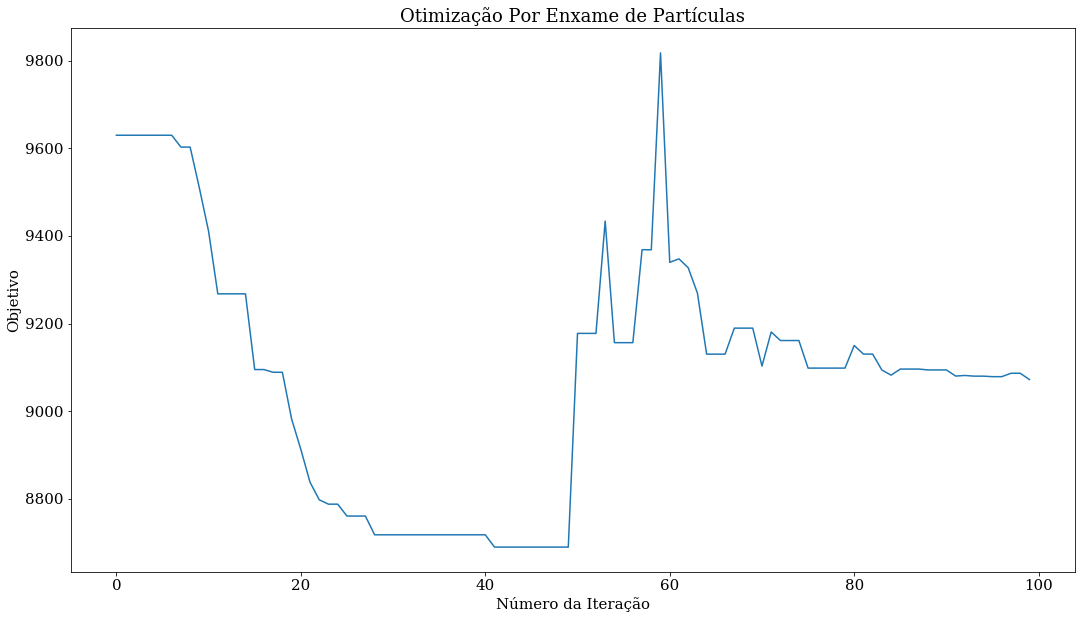

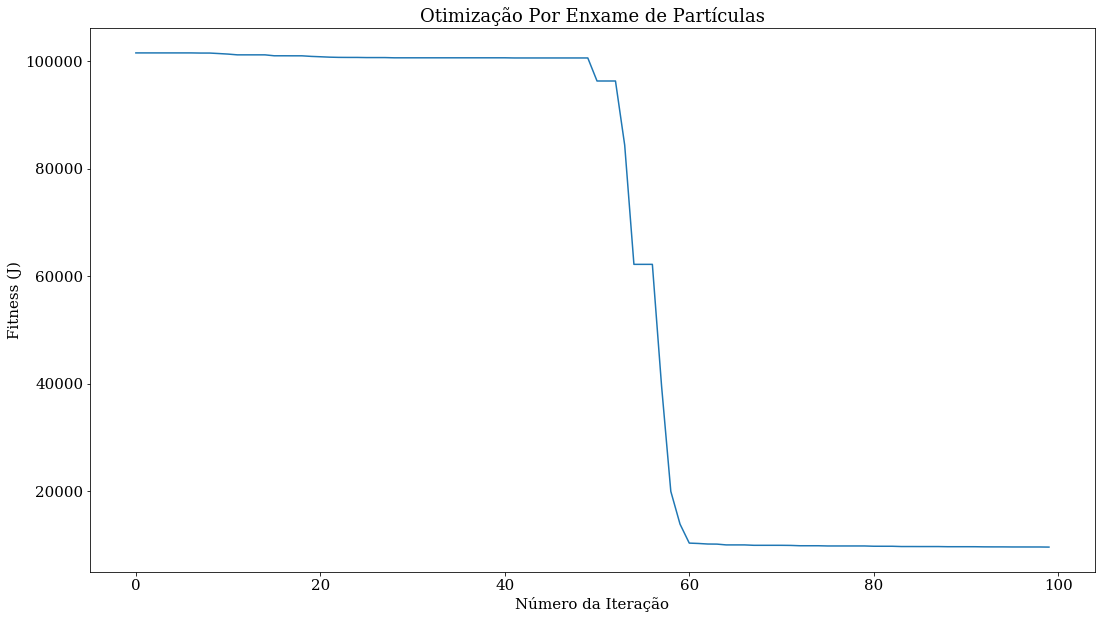

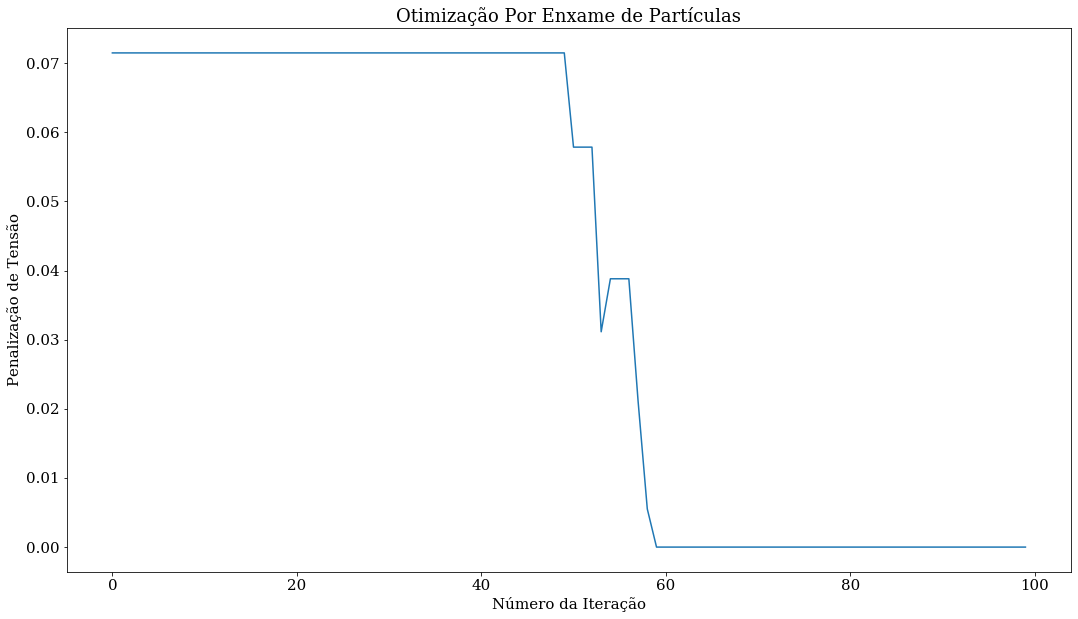

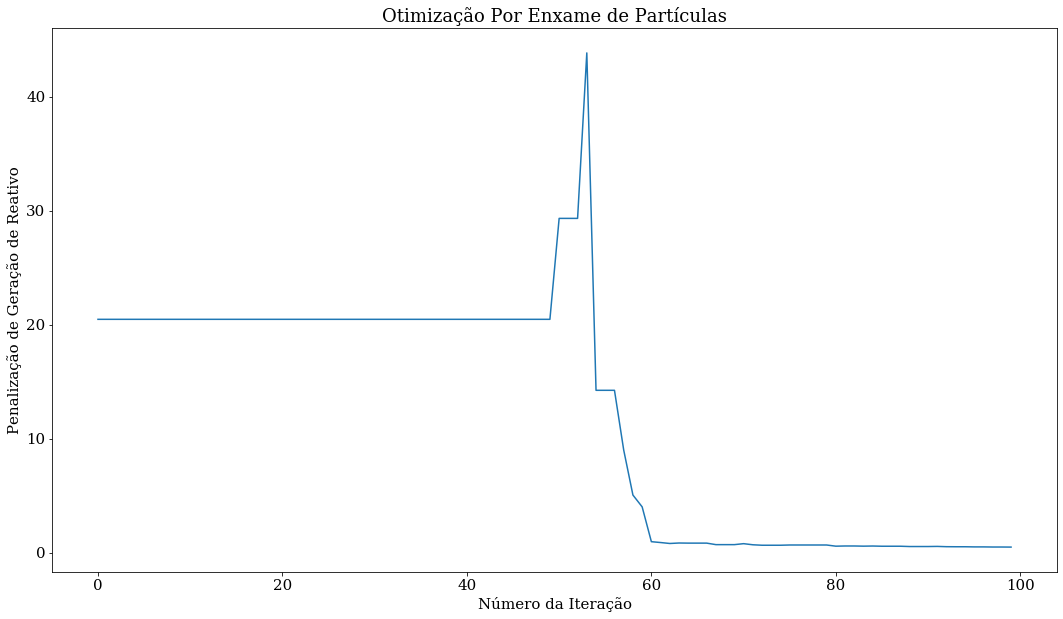

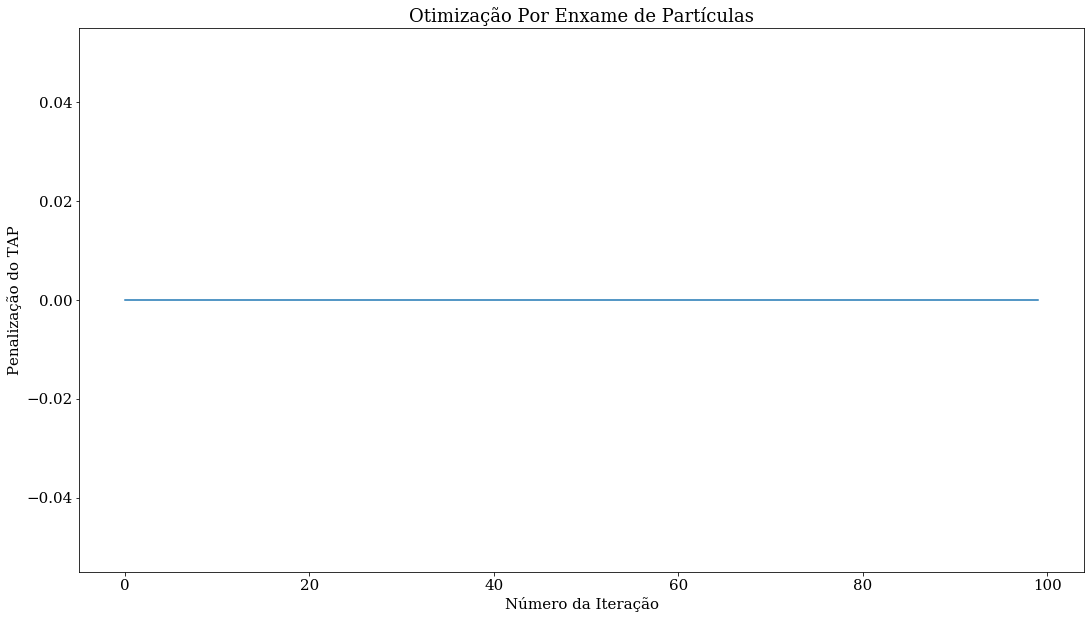

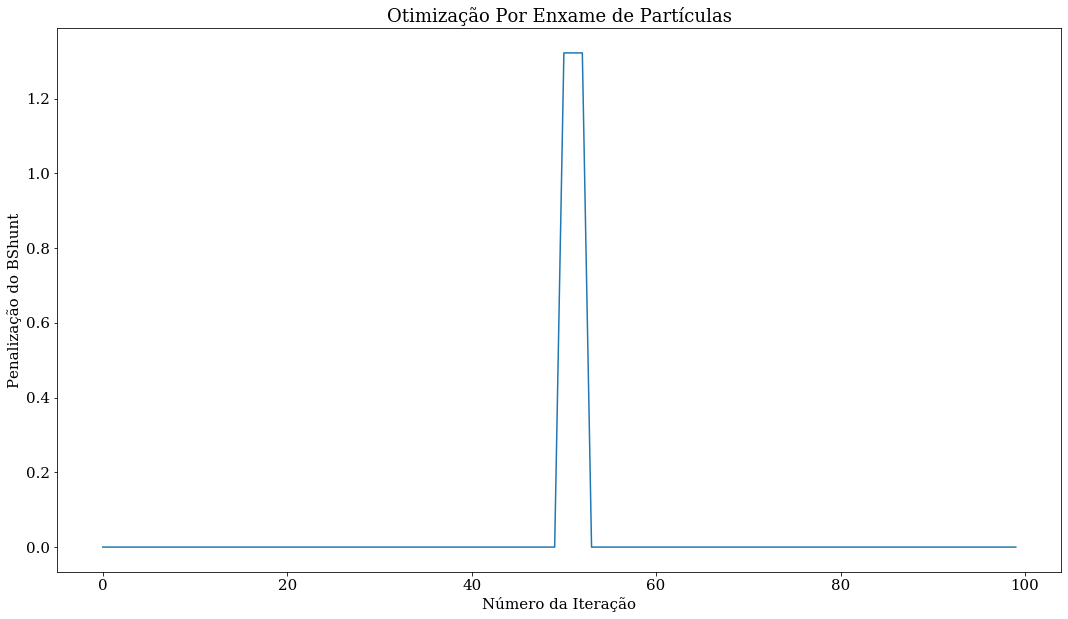

In [22]:
j_2,obj_2,pen_v,pen_gq,pen_tap,pen_bsh, pen_slack, global_best_2, tempo_2, delta = otimizacao_clpso_discreto_fpo(sep, refresh_gap = 0, p1_=0.7, p2_=0, zeta=1e6, psi=1e3, sigma=0, omega=0, neta=1e6, max_iter=100, n_particles=25,c1=1,c2=0,v_amp=0.1,valor_inicial=0,step=0.1, wmax=0.9,wmin=0.4,relatorio=True,inicial=False)   

In [413]:
j_2,obj_2,pen_v,pen_gq,pen_tap,pen_bsh, pen_slack, global_best_2, tempo_2, delta = otimizacao_pso_discreto_fpo(sep, refresh_gap = 0, p1_=0, p2_=0, zeta=1e6, psi=1e3, sigma=0, omega=0, neta=1e6, max_iter=100, n_particles=25,c1=2,c2=2,v_amp=0.1,valor_inicial=0,step=0.25, wmax=0.9,wmin=0.4,relatorio=True,inicial=False)   

 
Melhor Global da Iteração: 0
Objetivo: 168665.70662384664
Penalização de Tensão: 0.0
Penalização de Geração de Reativo: 39.20558204612233
Penalização do Gerador Slack (P): 0.0
Fitness: 207871.28866996896
Tempo:  0.8787996768951416
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 1
Objetivo: 154030.91662195005
Penalização de Tensão: 0.006185123078352506
Penalização de Geração de Reativo: 47.013294052247275
Penalização do Gerador Slack (P): 0.0
Fitness: 207229.33375254984
Tempo:  0.9654815196990967
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
 
Melhor Global da Iteração: 2
Objetivo: 150812.59765642148
Penalização de Tensão: 3.4332275444803884e-07
Penalização de Geração de Reativo: 30.723352293921486
Penalização do Gerador Slack (P): 0.0
Fitness: 181536.29327309743
Tempo:  0.9007322788238525
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 


KeyboardInterrupt: 

In [500]:
gbest=np.copy(global_best_2)

# gbest = cria_enxame_fpo(sep,1)[0]

gbest[n_vgen:n_tap+n_vgen] = discreto_tap(gbest,n_tap,n_vgen,n_bshunt,sep)
gbest[n_tap+n_vgen:n_tap+n_vgen+n_bshunt] = discreto_bshunt(gbest,n_tap,n_vgen,n_bshunt,sep)
gbest[n_vgen+n_tap+n_bshunt:n_vgen+n_tap+n_bshunt+n_gens] = poz(n_vgen, n_tap, n_bshunt, n_gens, gbest, sep)[n_vgen+n_tap+n_bshunt:n_vgen+n_tap+n_bshunt+n_gens] 


In [501]:
gbest[n_vgen+n_tap+n_bshunt:n_vgen+n_tap+n_bshunt+n_gens]

array([0.4977301 , 0.38926961, 0.49294945, 0.2160016 , 2.84199892,
       0.73560885, 0.37364174, 0.31558706, 0.02677931, 0.36283807,
       1.38907475, 2.07283469, 0.25305066, 0.00532604, 0.33564756,
       0.4611121 , 0.35920146, 0.3       , 0.55      , 0.31529936,
       1.52593611, 0.40887278, 0.41158033, 0.32589208, 1.55      ,
       1.319655  , 0.50856918, 2.63517036, 2.4522744 , 0.32724693,
       0.47432571, 0.60215168, 0.49235418, 0.39180245, 0.42472031,
       2.85749759, 0.31350246, 0.01244879, 3.59384149, 0.21306327,
       0.27024292, 0.3052614 , 0.33692081, 1.76044668, 0.33061453,
       0.09245777, 0.51451159, 0.49195476, 0.52930008, 0.30510729,
       0.22751407, 0.48806887, 0.4496775 ])

In [502]:
new = validacao_fpo_q(sep,gbest) 
# new = validacao_fpo(sep,gbest) 


Função Objetivo:

137479.92527724704
 
Penalização de Violação de Tensão [PU]:

0.0
 
Penalização de Violação de Geração de Reativo [PU]:

2.6901596002909534e-08
 
Penalização de Violação de Geração de Ativo (Slack) [PU]:

0.0
 


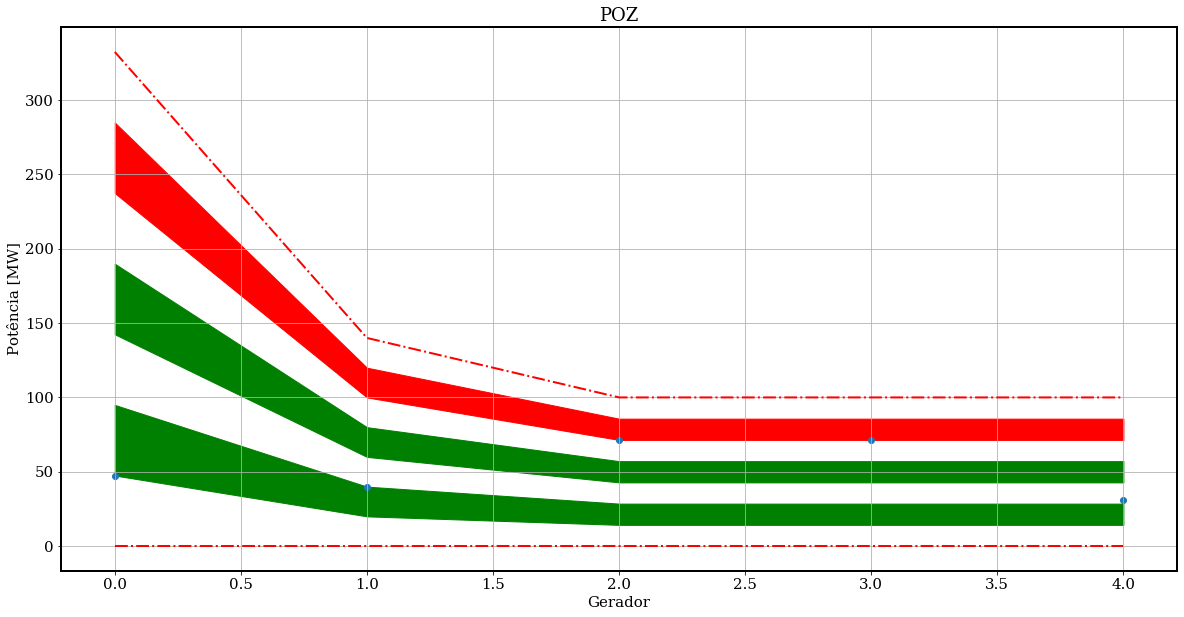

In [271]:
if len(sep.bus)==14:

    p = np.concatenate((sep.res_ext_grid['p_mw'].values,sep.gen['p_mw'].values))

    max_p = np.concatenate((sep.ext_grid['max_p_mw'].values,sep.gen['max_p_mw'].values))

    min_p = np.concatenate((sep.ext_grid['min_p_mw'].values,sep.gen['min_p_mw'].values))

    plt.fill_between(np.arange(0,len(sep.gen['p_mw'].values)+1,1), max_p*1/7,max_p*2/7, color='green')

    plt.fill_between(np.arange(0,len(sep.gen['p_mw'].values)+1,1), max_p*3/7,max_p*4/7, color='green')

    plt.fill_between(np.arange(0,len(sep.gen['p_mw'].values)+1,1), max_p*5/7,max_p*6/7, color='red')

    plt.plot(max_p, '-.', color='red')

    plt.plot(min_p, '-.', color='red')

    plt.scatter(np.arange(0,len(sep.gen['p_mw'].values)+1,1),p)

    plt.title('POZ')

    plt.xlabel('Gerador')

    plt.ylabel('Potência [MW]')

    plt.grid()

In [503]:
from apopt_teste import automatiza_apopt

solucao_continua,sep_atualizado,tensao,t,s, pgs,obj = automatiza_apopt(sep, verbose=True, travado=False)

[0.     0.     0.     0.     0.     0.     0.     0.638  0.     0.808
 0.     0.0445 0.164 ]
0
-0.03
apm 187.116.66.4_gk_model25 <br><pre> ----------------------------------------------------------------
 APMonitor, Version 1.0.1
 APMonitor Optimization Suite
 ----------------------------------------------------------------
 
 
 --------- APM Model Size ------------
 Each time step contains
   Objects      :            1
   Constants    :            0
   Variables    :          584
   Intermediates:            0
   Connections  :           55
   Equations    :          399
   Residuals    :          399
 
 Number of state variables:            584
 Number of total equations: -          399
 Number of slack variables: -          108
 ---------------------------------------
 Degrees of freedom       :             77
 
 ----------------------------------------------
 Steady State Optimization with APOPT Solver
 ----------------------------------------------
Iter:     1 I:  0 Tm:      2.07

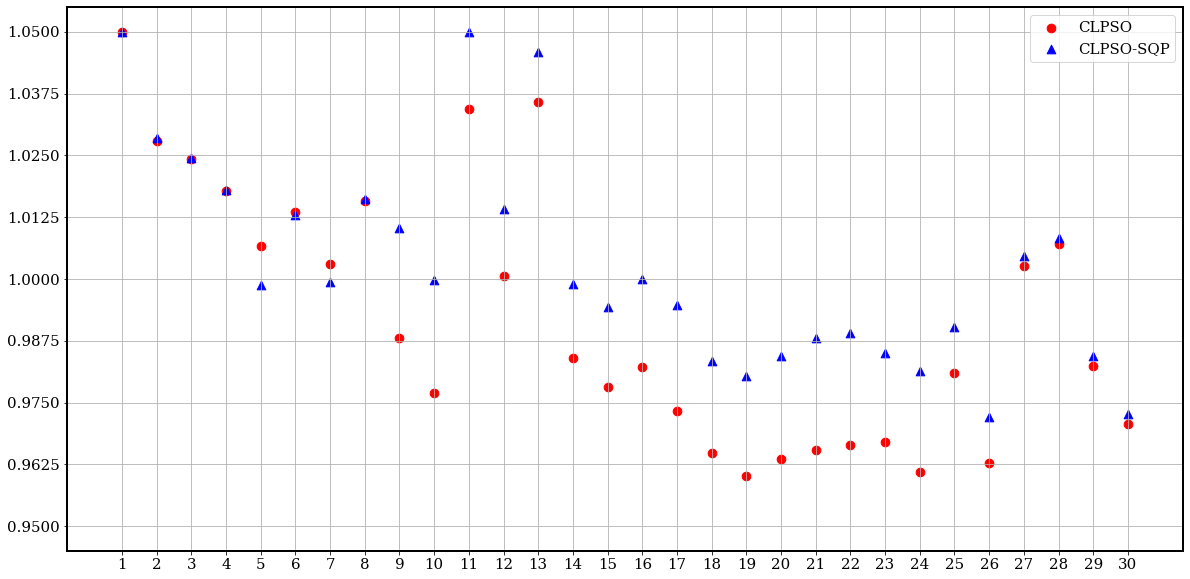

In [360]:
plt.scatter(np.arange(1,31,1),sep.res_bus['vm_pu'], marker='o', color='red', s=75, label='CLPSO')
plt.scatter(np.arange(1,31,1),sep_atualizado.res_bus['vm_pu'], marker='^', color='blue', s=75, label='CLPSO-SQP')
# plt.plot(np.ones(31)*1.05, '--', color='orange', label='$\overline{V}$')
# plt.plot(np.ones(31)*0.95, '-.', color='purple', label='$\underline{V}$')
plt.xticks(np.arange(1,31,1))
plt.ylim((0.945,1.055))
plt.yticks(np.arange(0.95,1.05,0.0125))
plt.grid()
plt.legend()
plt.rcParams['axes.linewidth'] = 2

In [216]:
gbest

array([1.02942801e+00, 1.01301248e+00, 9.86354835e-01, 1.01527413e+00,
       1.05000000e+00, 9.60000000e-01, 9.60000000e-01, 9.50000000e-01,
       3.00000000e-02, 4.00000000e-01, 2.85714286e-01, 2.85714286e-01,
       2.85714286e-01, 8.73491308e+03, 4.76837156e-08, 0.00000000e+00,
       0.00000000e+00, 1.16194769e-28, 0.00000000e+00, 8.73496076e+03])

In [53]:

gbest[n_vgen+n_tap+n_bshunt:n_vgen+n_tap+n_bshunt+n_gens] = pot.copy()

In [54]:
np.round(poz(n_vgen, n_tap, n_bshunt, n_gens, gbest, sep)[n_vgen+n_tap+n_bshunt:n_vgen+n_tap+n_bshunt+n_gens],6) 

array([0.35, 0.25, 0.25, 0.25, 0.  ])

In [55]:
print(global_best_2[n_vgen+n_tap+n_bshunt:n_vgen+n_tap+n_bshunt+n_gens])

print(pot)

[0.35067792 0.25100312 0.26130214 0.25817731 0.00036445]
[0.35, 0.25, 0.25, 0.25, 0.0]


In [169]:
sep.gen

,bus,controllable,in_service,name,p_mw,scaling,sn_mva,type,vm_pu,slack,max_p_mw,min_p_mw,max_q_mvar,min_q_mvar
0,0,True,True,None,1.129896,1.0,NaN,None,1.007892,False,100.0,0.0,15.0,-5.0
1,3,True,True,None,0.650657,1.0,NaN,None,1.018107,False,100.0,0.0,300.0,-300.0
2,5,True,True,None,0.098465,1.0,NaN,None,1.008397,False,100.0,0.0,50.0,-13.0
3,7,True,True,None,0.432295,1.0,NaN,None,1.022830,False,100.0,0.0,300.0,-300.0
4,9,True,True,None,412.478599,1.0,NaN,None,1.025320,False,550.0,0.0,200.0,-147.0
5,11,True,True,None,92.539089,1.0,NaN,None,1.006782,False,185.0,0.0,120.0,-35.0
6,14,True,True,None,1.897480,1.0,NaN,None,0.982300,False,100.0,0.0,30.0,-10.0
7,17,True,True,None,25.328123,1.0,NaN,None,0.987748,False,100.0,0.0,50.0,-16.0
8,18,True,True,None,25.057964,1.0,NaN,None,0.983112,False,100.0,0.0,24.0,-8.0
9,23,True,True,None,25.148443,1.0,NaN,None,1.015479,False,100.0,0.0,300.0,-300.0


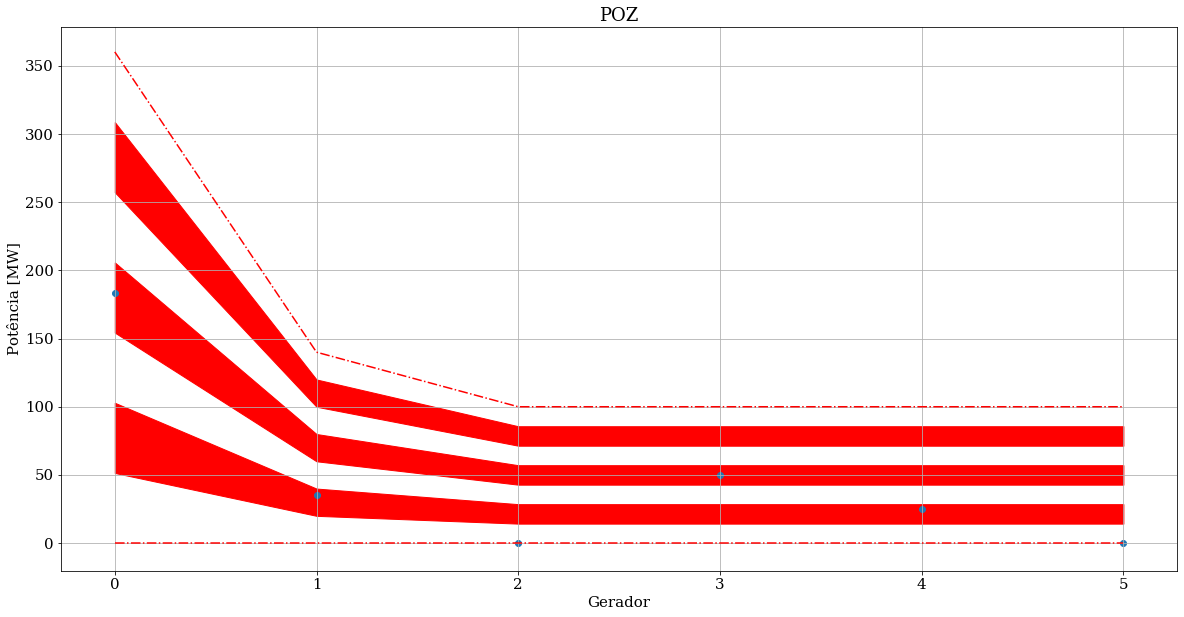

In [43]:
sep = sep_atualizado
p = np.concatenate((sep.res_ext_grid['p_mw'].values,sep.gen['p_mw'].values))

max_p = np.concatenate((sep.ext_grid['max_p_mw'].values,sep.gen['max_p_mw'].values))


min_p = np.concatenate((sep.ext_grid['min_p_mw'].values,sep.gen['min_p_mw'].values))

plt.fill_between(np.arange(0,len(sep.gen['p_mw'].values)+1,1), max_p*1/7,max_p*2/7, color='red')

plt.fill_between(np.arange(0,len(sep.gen['p_mw'].values)+1,1), max_p*3/7,max_p*4/7, color='red')

plt.fill_between(np.arange(0,len(sep.gen['p_mw'].values)+1,1), max_p*5/7,max_p*6/7, color='red')

plt.plot(max_p, '-.', color='red')

plt.plot(min_p, '-.', color='red')

plt.scatter(np.arange(0,len(sep.gen['p_mw'].values)+1,1),p)

plt.title('POZ')

plt.xlabel('Gerador')

plt.ylabel('Potência [MW]')

plt.grid()

In [45]:
sep_atualizado.gen

,bus,controllable,in_service,name,p_mw,scaling,sn_mva,type,vm_pu,slack,max_p_mw,min_p_mw,max_q_mvar,min_q_mvar,min_vm_pu,max_vm_pu
0,1,True,True,None,35.0,1.0,NaN,None,1.022353,False,140.0,0.0,50,-40,0.95,1.05
1,4,True,True,None,0.0,1.0,NaN,None,0.996061,False,100.0,0.0,40,-40,0.95,1.05
2,7,True,True,None,50.0,1.0,NaN,None,1.018026,False,100.0,0.0,40,-10,0.95,1.05
3,10,True,True,None,25.0,1.0,NaN,None,1.042399,False,100.0,0.0,24,-6,0.95,1.05
4,12,True,True,None,0.0,1.0,NaN,None,1.024511,False,100.0,0.0,24,-6,0.95,1.05


In [ ]:
sep

In [ ]:
gbest = np.array([   1.05,       1.02777271, 1.00059028, 0.99877433, 1.04651482,
                  1,1.01,1.01,0.05,0.40        ,  .1428571429,   0.        ,
         0.])


# #         1.02, 0.95, 1.02, 0.05, .35, .25, 0.151032694,0.25, 0,0,0,0,0,0,0])


validacao_fpo_q(sep_atualizado,gbest)



In [ ]:
ak = np.array([0.0430293, 0.25,      0.01,      0.01,      0.01     ])
bk = np.array([20., 20., 40., 40., 40.])
ck = np.array([0., 0., 0., 0., 0.])
ek = np.array([285.05742575,192.5,102.5,102.5,102.5])
fk = np.array([0.03780497, 0.08975979, 0.12566371, 0.12566371, 0.12566371])



In [ ]:
pg=p
np.abs(ek*np.sin(fk*(0-pg)))


In [ ]:
sep_atualizado.gen

In [ ]:
140*2/7

In [ ]:
sep_atualizado.res_ext_grid

In [ ]:
332.4*5/7

In [ ]:
sep_14.res_bus

In [19]:
sep_14.res_line['pl_mw'].sum() + sep_14.res_line['pl_mw'].sum()

13.393272357163312

In [48]:
lista_nan = []
lista_number = []

for val in sep_300.trafo['tap_neutral'].values:
    
    
    if str(val) == 'nan':
        
        lista_nan.append(val)

    else: lista_number.append(val)

In [49]:
sep_14 = case14()

sep_118 = case118()

sep_300 = case300()

sep_30 = case_ieee30()

v_init30 = inicializa_sep(sep_30,algorithm='fdbx', relatorio=False)

sep_14 = case14()

v_init14 = inicializa_sep(sep_14,algorithm='fdbx', relatorio=False)

sep_118 = case118()

v_init118 = inicializa_sep(sep_118,algorithm='fdbx', relatorio=False)

v_init300 = inicializa_sep(sep_300,algorithm='fdbx', relatorio=False)

sep = sep_118

In [58]:
p = cria_enxame_fpo(sep,1)


In [64]:

p[0:n_vgen] = 0.9

In [65]:
fluxo_de_pot_fpo_dc(p, sep)

array([[9.00000000e-01, 9.00000000e-01, 9.00000000e-01, 9.00000000e-01,
        9.00000000e-01, 9.00000000e-01, 9.00000000e-01, 9.00000000e-01,
        9.00000000e-01, 9.00000000e-01, 9.00000000e-01, 9.00000000e-01,
        9.00000000e-01, 9.00000000e-01, 9.00000000e-01, 9.00000000e-01,
        9.00000000e-01, 9.00000000e-01, 9.00000000e-01, 9.00000000e-01,
        9.00000000e-01, 9.00000000e-01, 9.00000000e-01, 9.00000000e-01,
        9.00000000e-01, 9.00000000e-01, 9.00000000e-01, 9.00000000e-01,
        9.00000000e-01, 9.00000000e-01, 9.00000000e-01, 9.00000000e-01,
        9.00000000e-01, 9.00000000e-01, 9.00000000e-01, 9.00000000e-01,
        9.00000000e-01, 9.00000000e-01, 9.00000000e-01, 9.00000000e-01,
        9.00000000e-01, 9.00000000e-01, 9.00000000e-01, 9.00000000e-01,
        9.00000000e-01, 9.00000000e-01, 9.00000000e-01, 9.00000000e-01,
        9.00000000e-01, 9.00000000e-01, 9.00000000e-01, 9.00000000e-01,
        9.00000000e-01, 9.00000000e-01, 9.00000000e-01, 9.000000

In [60]:
sep.res_line

,p_from_mw,q_from_mvar,p_to_mw,q_to_mvar,pl_mw,ql_mvar,i_from_ka,i_to_ka,i_ka,vm_from_pu,va_from_degree,vm_to_pu,va_to_degree,loading_percent
0,19.631282,0.0,-19.631282,0.0,0.0,0.0,0.082131,0.082131,0.082131,1.0,42.354575,1.0,41.230910,0.198296
1,29.368718,0.0,-29.368718,0.0,0.0,0.0,0.122870,0.122870,0.122870,1.0,42.354575,1.0,41.641108,0.296654
2,19.747551,0.0,-19.747551,0.0,0.0,0.0,0.082618,0.082618,0.082618,1.0,42.595476,1.0,42.505186,0.199470
3,-13.963897,0.0,13.963897,0.0,0.0,0.0,0.058421,0.058421,0.058421,1.0,41.641108,1.0,42.505186,0.141049
4,1.993743,0.0,-1.993743,0.0,0.0,0.0,0.008341,0.008341,0.008341,1.0,42.505186,1.0,42.443500,0.020139
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
168,17.973408,0.0,-17.973408,0.0,0.0,0.0,0.075195,0.075195,0.075195,1.0,44.025678,1.0,43.262596,0.181550
169,4.026592,0.0,-4.026592,0.0,0.0,0.0,0.016846,0.016846,0.016846,1.0,43.286589,1.0,43.262596,0.040673
170,20.000000,0.0,-20.000000,0.0,0.0,0.0,0.083674,0.083674,0.083674,1.0,41.243923,1.0,39.639641,0.202020
171,-5.364098,0.0,5.364098,0.0,0.0,0.0,0.022442,0.022442,0.022442,1.0,10.064248,1.0,10.212078,0.054183


In [67]:
sep.res_gen

,p_mw,q_mvar,va_degree,vm_pu
0,90.0,-3.104097,26.255339,0.9
1,90.0,-15.009646,26.890914,0.9
2,90.0,15.929766,26.573115,0.9
3,90.0,63.138428,27.645762,0.9
4,90.0,-51.042152,30.878963,0.9
5,90.0,91.291736,25.472915,0.9
6,90.0,7.160452,24.537825,0.9
7,90.0,28.426323,25.761176,0.9
8,90.0,-14.274169,24.810792,0.9
9,90.0,-14.907643,28.093776,0.9


In [54]:
sep_14 = case14()
sep_118 = case118()
sep_300 = case300()
sep_30 = case_ieee30()

v_init30 = inicializa_sep(sep_30,algorithm='fdbx', relatorio=False)

sep_14 = case14()
v_init14 = inicializa_sep(sep_14,algorithm='fdbx', relatorio=False)
sep_118 = case118()
v_init118 = inicializa_sep(sep_118,algorithm='fdbx', relatorio=False)

sep2 = sep_118

In [56]:
fluxo_de_pot_fpo(p,sep2)

array([[ 1.00044000e+00,  9.71487881e-01,  1.02371652e+00,
         1.01310572e+00,  9.72373429e-01,  9.91247593e-01,
         1.01862557e+00,  1.02847712e+00,  9.92509611e-01,
         1.03135656e+00,  9.58444205e-01,  1.03606672e+00,
         1.04098290e+00,  9.62610002e-01,  1.02700102e+00,
         9.83623516e-01,  1.02959670e+00,  1.04586036e+00,
         9.97691788e-01,  9.67258956e-01,  1.05789927e+00,
         9.48005723e-01,  1.03157288e+00,  1.02387769e+00,
         9.70864827e-01,  9.57087725e-01,  1.04133161e+00,
         1.01391618e+00,  1.04418534e+00,  1.00746733e+00,
         1.02817730e+00,  1.05254629e+00,  9.65714860e-01,
         9.41964604e-01,  9.91937422e-01,  9.66301550e-01,
         9.55210778e-01,  9.41756813e-01,  9.67184621e-01,
         9.94929076e-01,  1.01881890e+00,  1.01202422e+00,
         9.42775793e-01,  1.05668454e+00,  9.65370500e-01,
         1.00766734e+00,  9.56767736e-01,  9.43901292e-01,
         9.66627092e-01,  9.45028495e-01,  1.04984355e+0

In [57]:
sep2.res_line

,p_from_mw,q_from_mvar,p_to_mw,q_to_mvar,pl_mw,ql_mvar,i_from_ka,i_to_ka,i_ka,vm_from_pu,va_from_degree,vm_to_pu,va_to_degree,loading_percent
0,-4.095040,-23.429482,4.259089,21.512821,0.164049,-1.916661,0.102428,0.092153,0.102428,0.971488,28.226451,0.995629,28.069770,0.247300
1,-30.368415,-21.721777,30.555965,21.302918,0.187550,-0.418859,0.160793,0.158238,0.160793,0.971488,28.226451,0.984833,28.833700,0.388214
2,-48.290765,155.142100,48.734717,-153.346854,0.443952,1.795246,0.664036,0.664889,0.664889,1.023717,32.463738,1.012465,32.827812,1.605290
3,-66.136961,-9.573585,67.240530,11.686166,1.103569,2.112581,0.283887,0.282016,0.283887,0.984833,28.833700,1.012465,32.827812,0.685408
4,94.650843,-20.211576,-93.566782,23.668147,1.084061,3.456571,0.399933,0.398561,0.399933,1.012465,32.827812,1.013106,29.841971,0.965588
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
168,17.003761,-11.430676,-16.933013,9.912933,0.070748,-1.517743,0.089048,0.084810,0.089048,0.962610,29.290171,0.967923,28.409263,0.214996
169,5.074533,16.687961,-5.066987,-16.912933,0.007546,-0.224972,0.075243,0.076314,0.076314,0.969847,28.417866,0.967923,28.409263,0.184250
170,20.143357,4.951665,-20.000000,-8.000000,0.143357,-3.048335,0.085196,0.089842,0.089842,1.018626,28.599894,1.003085,27.143996,0.216913
171,17.410654,-16.509799,-17.324221,15.669784,0.086433,-0.840014,0.103797,0.100494,0.103797,0.967104,3.437125,0.972489,2.786039,0.250606


In [42]:
sep.res_bus

,vm_pu,va_degree,p_mw,q_mvar
0,0.955000,7.189484,21.305545,30.104097
1,0.971393,7.459086,20.000000,9.000000
2,0.967692,7.592643,39.000000,10.000000
3,0.998000,10.372016,-16.190383,27.009646
4,1.001985,10.534323,0.000000,40.158928
...,...,...,...,...
113,0.960093,7.870726,8.000000,3.000000
114,0.960023,7.812592,22.000000,7.000000
115,1.005000,5.376246,136.142479,-51.087088
116,0.973824,6.726929,20.000000,8.000000
